#### Explore the ready dataset Iisights,distribution,charachtristics ...

In [1]:

from modbus import ModbusDataset,CSVDataset
import pandas as pd 
import re   
# import torch
from torch.utils.data import DataLoader
import numpy as np
# import json
from utils import merge_datasets
from collections import Counter
import matplotlib.pyplot as plt
import os 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import time
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [3]:
# uncommit if the Labeled_CICMODBUS2023.zip not extracted yet! 
# import zipfile
# import os

# # from Labeling notebook , This file will be achieved.
# zip_path = "./Labeled_CICMODBUS2023.zip"
# extract_dir = "./dataset"

# # Create directory if missing
# os.makedirs(extract_dir, exist_ok=True)

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)



In [2]:
dataset_directory = "./dataset" # change this to the folder contain benign and attack subdirs
modbus = ModbusDataset(dataset_directory,"ready",batch_size=5)
modbus.summary_print()

 The CIC Modbus Dataset contains network (pcap) captures and attack logs from a simulated substation network.
                The dataset is categorized into two groups: an attack dataset and a benign dataset
                The attack dataset includes network traffic captures that simulate various types of Modbus protocol attacks in a substation environment.
                The attacks are reconnaissance, query flooding, loading payloads, delay response, modify length parameters, false data injection, stacking Modbus frames, brute force write and baseline replay.
                These attacks are based of some techniques in the MITRE ICS ATT&CK framework.
                On the other hand, the benign dataset consists of normal network traffic captures representing legitimate Modbus communication within the substation network.
                The purpose of this dataset is to facilitate research, analysis, and development of intrusion detection systems, anomaly detection algorithms and

In [5]:
def find_global_stats(csv_files,category,return_fitted_scalers=False,unuseful_features = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp']):
    """
    Analyzes multiple CSV files, grouped by their subdirectory, to calculate global statistics
    (count, mean, std, min, max, duplicates) for numeric features and label counts for the 'Label' column.
    It can also return and save fitted MinMaxScaler and StandardScaler objects for future use.

    Args:
        csv_files (list): CSV dataset files to be analyzed.
        category (str): A string representing the category of the Attack scenario 
        return_fitted_scalers (bool, optional): If True, the function will return a dictionary
                                                of fitted MinMaxScaler and StandardScaler objects
                                                for each numeric column and save them to disk.
                                                Defaults to False.
        unuseful_features (list, optional): A list of column names to be excluded from the
                                            numeric feature analysis. Defaults to
                                            ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'].

    Returns:
        tuple: A tuple containing:
            - all_global_stats (dict): A nested dictionary where the first level keys are
                                       subdirectory names. The second level contains another
                                       dictionary with numeric column names as keys, and
                                       their calculated statistics (count, mean, std, min, max, duplicates)
                                       as values.
            - all_label_counts (dict): A dictionary where keys are subdirectory names and values
                                       are dictionaries of label counts for the 'Label' column
                                       within each subdirectory's files.
            - all_fitted_scalers (dict, optional): Returned only if `return_fitted_scalers` is True.
                                                  A dictionary where keys are subdirectory names,
                                                  and values are dictionaries containing fitted
                                                  MinMaxScaler and StandardScaler objects for each
                                                  numeric column.
            - numeric_cols (list, optional): Returned only if `return_fitted_scalers` is True.
                                            A list of the numeric columns for which statistics
                                            and scalers were calculated.
    """
    print("-"*40,category,"-"*40)
    # Group files by their subdirectory
    dir_groups = {}
    for file in csv_files:
        subdir = os.path.basename(os.path.dirname(os.path.dirname(file)))
        # Clean subdirectory name by removing '-network-capture' and '-wide-pcap-capture'
        subdir = re.sub(r'-(network|wide)-(pcap-)?capture(s?)', '', subdir)
        if subdir not in dir_groups:
            dir_groups[subdir] = []
        dir_groups[subdir].append(file)
    
    all_global_stats = {}
    all_label_counts = {}
    if return_fitted_scalers:
        all_fitted_scalers = {} # To store the fitted MinMaxScaler and StandardScaler instances
    
    for subdir, files in dir_groups.items():
        # Read first file to get numeric columns
        first_df = pd.read_csv(files[0], encoding='cp1252')
        numeric_cols = first_df.drop(columns=unuseful_features, errors='ignore').select_dtypes(include=['number']).columns.tolist()
        # Initialize trackers for statistics
        stats = {
            col: {
                'count': 0, 
                'sum': 0.0, 
                'sum_sq': 0.0, 
                'min': float('inf'), 
                'max': float('-inf'),
                'duplicates': 0,
            } for col in numeric_cols
        }
        
        label_counts = Counter()
        unique_values = {col: set() for col in numeric_cols}
        len_csv_files = len(files)
        min_max_scalers = {col: MinMaxScaler() for col in numeric_cols}
        standard_scalers = {col: StandardScaler() for col in numeric_cols}

        for file_index,file in enumerate(files):
            # Read only necessary columns (numeric_cols + Label)
            print("node : ",subdir,", file_",file_index+1,"/",len_csv_files,":",file)
            df = pd.read_csv(file, encoding='cp1252', usecols=numeric_cols + ['Label'], low_memory=False)
            # Count labels in the current file
            if 'Label' in df.columns:
                label_counts.update(df['Label'])
            
            for col in numeric_cols:
                # Track unique values for duplicates
                current_values = set(df[col])
                stats[col]['duplicates'] += len(df[col]) - len(current_values - unique_values[col])
                unique_values[col].update(current_values)
                
                # Update other statistics (only for non-NaN values)
                valid_data = df[col]
                data_to_fit = valid_data.values.reshape(-1, 1) # Reshape for scikit-learn
                min_max_scalers[col].partial_fit(data_to_fit)
                standard_scalers[col].partial_fit(data_to_fit)
                
        
        # Compute final statistics for numeric columns
        feature = {}
        for col in numeric_cols:
            mm_scaler = min_max_scalers[col]
            std_scaler = standard_scalers[col]
            # The 'n_samples_seen_' attribute from StandardScaler gives the total count of samples seen
            sk_count = std_scaler.n_samples_seen_
            sk_mean = std_scaler.mean_[0]
            sk_std = np.sqrt(std_scaler.var_[0]) # Standard deviation is the square root of variance
            sk_min_val = mm_scaler.data_min_[0]
            sk_max_val = mm_scaler.data_max_[0]

            feature[col] = {
                'count':sk_count,
                'mean': sk_mean,
                'std': sk_std,
                'min': sk_min_val,
                'max': sk_max_val,
                'duplicates': stats[col]['duplicates']/ sk_count  
            }

        
        # Store results for this subdirectory
        all_global_stats[subdir] = feature
        all_label_counts[subdir] = dict(label_counts)
        # Store the fitted scaler objects for later use in scaling new data
        if return_fitted_scalers:
            all_fitted_scalers[subdir] = {
                'min_max_scalers': min_max_scalers,
                'standard_scalers': standard_scalers
            }

    if return_fitted_scalers:    
        return all_global_stats, all_label_counts ,all_fitted_scalers,numeric_cols
    else:
        return all_global_stats, all_label_counts


def print_statistics(_global_stats):

    for index, _global_stat in enumerate(_global_stats):
        global_stats_df = pd.DataFrame(_global_stats[_global_stat]).transpose()
        print("-"*80,"\nnode_", index," :",_global_stat,"\nflows count_",global_stats_df['count'].iloc[0])

        # Display with all rows and columns visible
        with pd.option_context('display.max_rows', None, 
                            'display.max_columns', None, 
                            'display.width', None,
                            'display.float_format', '{:.2f}'.format):  # Adjust decimal places as needed
            print(global_stats_df.drop(columns=['count']))
def plot_label_counts_subplots(all_label_counts):
    n_subdirs = len(all_label_counts)
    ncols = 2  
    nrows = (n_subdirs + 1) // 2  
    
    # Create subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows), squeeze=False)
    axes = axes.flatten() 
    
    # Plot each subdirectory's label counts
    for idx, (subdir, label_counts) in enumerate(all_label_counts.items()):
        labels = list(label_counts.keys())
        counts = list(label_counts.values())
        
        bars = axes[idx].bar(labels, counts, color=['#36A2EB', '#FF6384', '#FFCE56', '#4BC0C0', '#9966FF'][:len(labels)])
        axes[idx].set_title(f'Label Distribution: {subdir}')
        axes[idx].set_xlabel('Labels')
        axes[idx].set_ylabel('Count')
        # Increase rotation and adjust font size to reduce overlap
        axes[idx].tick_params(axis='x', rotation=60, labelsize=8)
        
        # Add count numbers on top of each bar
        for bar in bars:
            height = bar.get_height()
            axes[idx].text(
                bar.get_x() + bar.get_width() / 2,  
                height,  #
                f'{int(height)}',  
                ha='center',  
                va='bottom', 
                fontsize=9
            )
    axes[idx].set_ylim(0, max(counts) * 1.15)
    # Hide any unused subplots
    for idx in range(len(all_label_counts), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

#### the ICS statistics and label distribution


- Extract min, max, mean , std and duplicate ratio for each numerical feature (mirror switch)
- Duplicates are between 0 and 1 (from no duplicate  to nearly almost)
- Calculate global min max of benign dataset numeric values for later min_max scaling 
- Extract charachtristics of the ❗network-wide benign❗ node data as a generalization to all dataset


In [6]:
# #pre calculated numeric_cols with the enhanced CICFlowMeter 2019 
numeric_cols = ['Protocol', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWR Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg', 'Bwd Packet/Bulk Avg', 'Bwd Bulk Rate Avg', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'FWD Init Win Bytes', 'Bwd Init Win Bytes', 'Fwd Act Data Pkts', 'Bwd Act Data Pkts', 'Fwd Seg Size Min', 'Bwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'ICMP Code', 'ICMP Type', 'Fwd TCP Retrans. Count', 'Bwd TCP Retrans. Count', 'Total TCP Retrans. Count', 'Total Connection Flow Time']
# ### needed for scaling  (will change numeric_cols)
benign_wide_dir =[col for col in modbus.dataset["benign_dataset_dir"] if col.find("network-wide") != -1]
benign_wide_global_stats,benign_wide_label_counts ,benign_scalers,numeric_cols= find_global_stats(benign_wide_dir,"benign",return_fitted_scalers=True)


---------------------------------------- benign ----------------------------------------
node :  network-wide , file_ 1 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-25-labeled.csv
node :  network-wide , file_ 2 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-30-labeled.csv
node :  network-wide , file_ 3 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-26-labeled.csv
node :  network-wide , file_ 4 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-17-labeled.csv
node :  network-wide , file_ 5 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-18-labeled.csv
node :  network-wide , file_ 6 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-19-labeled.csv
node :  network-w

-------------------------------------------------------------------------------- 
node_ 0  : network-wide 
flows count_ 2822444.0
                                  mean          std   min            max  \
Protocol                          6.00         0.16  2.00          17.00   
Flow Duration              10297843.17  26824472.17  0.00   119999783.00   
Total Fwd Packet                  4.27         2.50  0.00         226.00   
Total Bwd packets                 3.30         1.65  0.00         210.00   
Total Length of Fwd Packet       17.41       189.83  0.00       52116.00   
Total Length of Bwd Packet        7.97        14.79  0.00        3914.00   
Fwd Packet Length Max             9.21        14.84  0.00         700.00   
Fwd Packet Length Min             0.01         1.08  0.00         118.00   
Fwd Packet Length Mean            1.92         7.00  0.00         230.60   
Fwd Packet Length Std             3.97         7.45  0.00         350.00   
Bwd Packet Length Max             

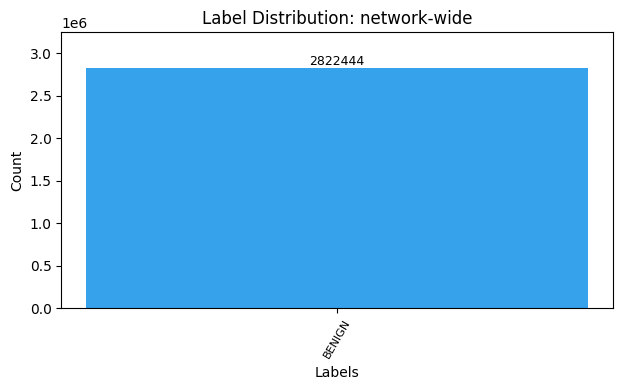

In [5]:
print_statistics(benign_wide_global_stats)
plot_label_counts_subplots(benign_wide_label_counts)
del benign_wide_label_counts,benign_wide_global_stats


#### compare our custom memory-friend statistics with the built-in pandas 

In [8]:
benign_wide_df = merge_datasets(benign_wide_dir) ##heavy memory usage (at least of 4 free GIG of RAM is suggested)
benign_wide_df=benign_wide_df.drop(columns=['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'])

In [9]:
pd.options.display.max_rows = 90
pd.options.display.max_columns= 90

benign_wide_df.describe().transpose()  ##heavy memory usage (at least another 4 free GIG of RAM is suggested)

,count,mean,std,min,25%,50%,75%,max
Protocol,2822444.0,6.002180e+00,1.555253e-01,2.0,6.000000,6.000000,6.000000e+00,1.700000e+01
Flow Duration,2822444.0,1.029784e+07,2.682448e+07,0.0,12.000000,1551.000000,4.491800e+04,1.199998e+08
Total Fwd Packet,2822444.0,4.274185e+00,2.495789e+00,0.0,1.000000,5.000000,6.000000e+00,2.260000e+02
Total Bwd packets,2822444.0,3.302945e+00,1.646330e+00,0.0,1.000000,4.000000,4.000000e+00,2.100000e+02
Total Length of Fwd Packet,2822444.0,1.741455e+01,1.898308e+02,0.0,0.000000,12.000000,1.200000e+01,5.211600e+04
Total Length of Bwd Packet,2822444.0,7.968790e+00,1.478770e+01,0.0,0.000000,10.000000,1.100000e+01,3.914000e+03
Fwd Packet Length Max,2822444.0,9.206532e+00,1.484285e+01,0.0,0.000000,12.000000,1.200000e+01,7.000000e+02
Fwd Packet Length Min,2822444.0,1.380718e-02,1.082329e+00,0.0,0.000000,0.000000,0.000000e+00,1.180000e+02
Fwd Packet Length Mean,2822444.0,1.918787e+00,7.004023e+00,0.0,0.000000,2.000000,2.400000e+00,2.306018e+02
Fwd Packet Length Std,2822444.0,3.973973e+00,7.452475e+00,0.0,0.000000,4.898979,5.366563e+00,3.500000e+02


In [10]:

benign_wide_df

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd RST Flags,Bwd RST Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWR Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Bwd Act Data Pkts,Fwd Seg Size Min,Bwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label
0,6,91780087,24,12,3030,228,253,0,126.25,128.965870,19,19,19.0,0.00000,35.497896,0.392242,2.622288e+06,8.222544e+06,40743450,17,91780087,3.990439e+06,9.938856e+06,40743450,286,91779242,8.343567e+06,1.332453e+07,40743779,21610,12,12,0,0,0,0,768,384,0.261495,0.130747,0,253,90.500000,116.442628,13558.885714,0,0,0,24,36,0,0,0,0.500000,90.500000,126.25,19.0,0.0,0.0,0.0,0.0,0.0,0.0,4,606,2,45,502,501,12,12,32,0,33313.200000,18134.806194,64281,22372,1.831644e+07,1.467954e+07,40743450,5069304,-1,-1,0,0,0,91780087,BENIGN
1,6,101963027,24,12,3030,228,253,0,126.25,128.965870,19,19,19.0,0.00000,31.952759,0.353069,2.913229e+06,9.016738e+06,40753004,16,101963027,4.433175e+06,1.089052e+07,40753004,291,101962713,9.269338e+06,1.454731e+07,40753387,22058,12,12,0,0,0,0,768,384,0.235379,0.117690,0,253,90.500000,116.442628,13558.885714,0,0,0,24,36,0,0,0,0.500000,90.500000,126.25,19.0,0.0,0.0,0.0,0.0,0.0,0.0,4,606,2,45,502,501,12,12,32,0,24286.200000,1092.059385,26032,23395,2.036383e+07,1.571515e+07,40753004,5071664,-1,-1,0,0,0,101963027,BENIGN
2,6,96863625,32,16,4040,304,253,0,126.25,128.270631,19,19,19.0,0.00000,44.846556,0.495542,2.060928e+06,5.875922e+06,25458268,13,96863625,3.124633e+06,7.036057e+06,25458268,255,96863291,6.457553e+06,9.112041e+06,25458564,21869,16,16,0,0,0,0,1024,512,0.330361,0.165181,0,253,90.500000,116.028977,13462.723404,0,0,0,32,48,0,0,0,0.500000,90.500000,126.25,19.0,0.0,0.0,0.0,0.0,0.0,0.0,4,577,2,43,502,501,16,16,32,0,24515.571429,3288.480290,31505,22161,1.380979e+07,8.687817e+06,25458268,5070642,-1,-1,0,0,0,224287869,BENIGN
3,6,107004998,16,8,2020,152,253,0,126.25,130.390951,19,19,19.0,0.00000,20.298117,0.224289,4.652391e+06,1.292504e+07,45819217,14,107004998,7.133667e+06,1.560618e+07,45819217,294,107004648,1.528638e+07,2.056467e+07,45819557,21813,8,8,0,0,0,0,512,256,0.149526,0.074763,0,253,90.500000,117.283380,13755.391304,0,0,0,16,24,0,0,0,0.500000,90.500000,126.25,19.0,0.0,0.0,0.0,0.0,0.0,0.0,5,673,2,50,502,501,8,8,32,0,22886.666667,767.342383,23759,22316,3.563806e+07,1.346962e+07,45819217,20364718,-1,-1,0,0,0,229321781,BENIGN
4,6,40762,2,2,10,0,10,0,5.00,7.071068,0,0,0.0,0.00000,245.326530,98.130612,1.358733e+04,2.341968e+04,40630,21,40762,4.076200e+04,0.000000e+00,40762,40762,111,1.110000e+02,0.000000e+00,111,111,1,0,0,0,0,0,64,64,49.065306,49.065306,0,10,2.500000,5.000000,25.000000,1,0,0,1,4,0,0,0,1.000000,2.500000,5.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,509,502,1,0,32,0,0.000000,0.000000,0,0,0.000000e+00,0.000000e+00,0,0,-1,-1,0,1,1,40762,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,

##### Identifying duplicate values


In [11]:
# Types of attacks & normal instances (BENIGN)
print(benign_wide_df['Label'].value_counts()) 
dups = benign_wide_df[benign_wide_df.duplicated()] ## heavy memory usage (at least another 4 free GIG of RAM is suggested)
print(f'Number of duplicates: {len(dups)}')
del dups
benign_wide_df.drop_duplicates(inplace = True)
print("shape after drop duplicates",benign_wide_df.shape)
# Checking for columns with zero standard deviation (the blank squares in the heatmap)
std = benign_wide_df.std(numeric_only = True)
zero_std_cols = std[std == 0].index.tolist()
print("zero variance columns (will be droped for the following analysis )",zero_std_cols)
benign_wide_df.drop(columns=zero_std_cols,inplace=True)
print("shape after drop  zero variance ",benign_wide_df.shape)


Label
BENIGN    2822444
Name: count, dtype: int64
Number of duplicates: 13666
shape after drop duplicates (2808778, 88)
zero variance columns (will be droped for the following analysis ) ['Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count', 'CWR Flag Count', 'ECE Flag Count', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg', 'Bwd Packet/Bulk Avg', 'Bwd Bulk Rate Avg', 'ICMP Code', 'ICMP Type']
shape after drop  zero variance  (2808778, 75)


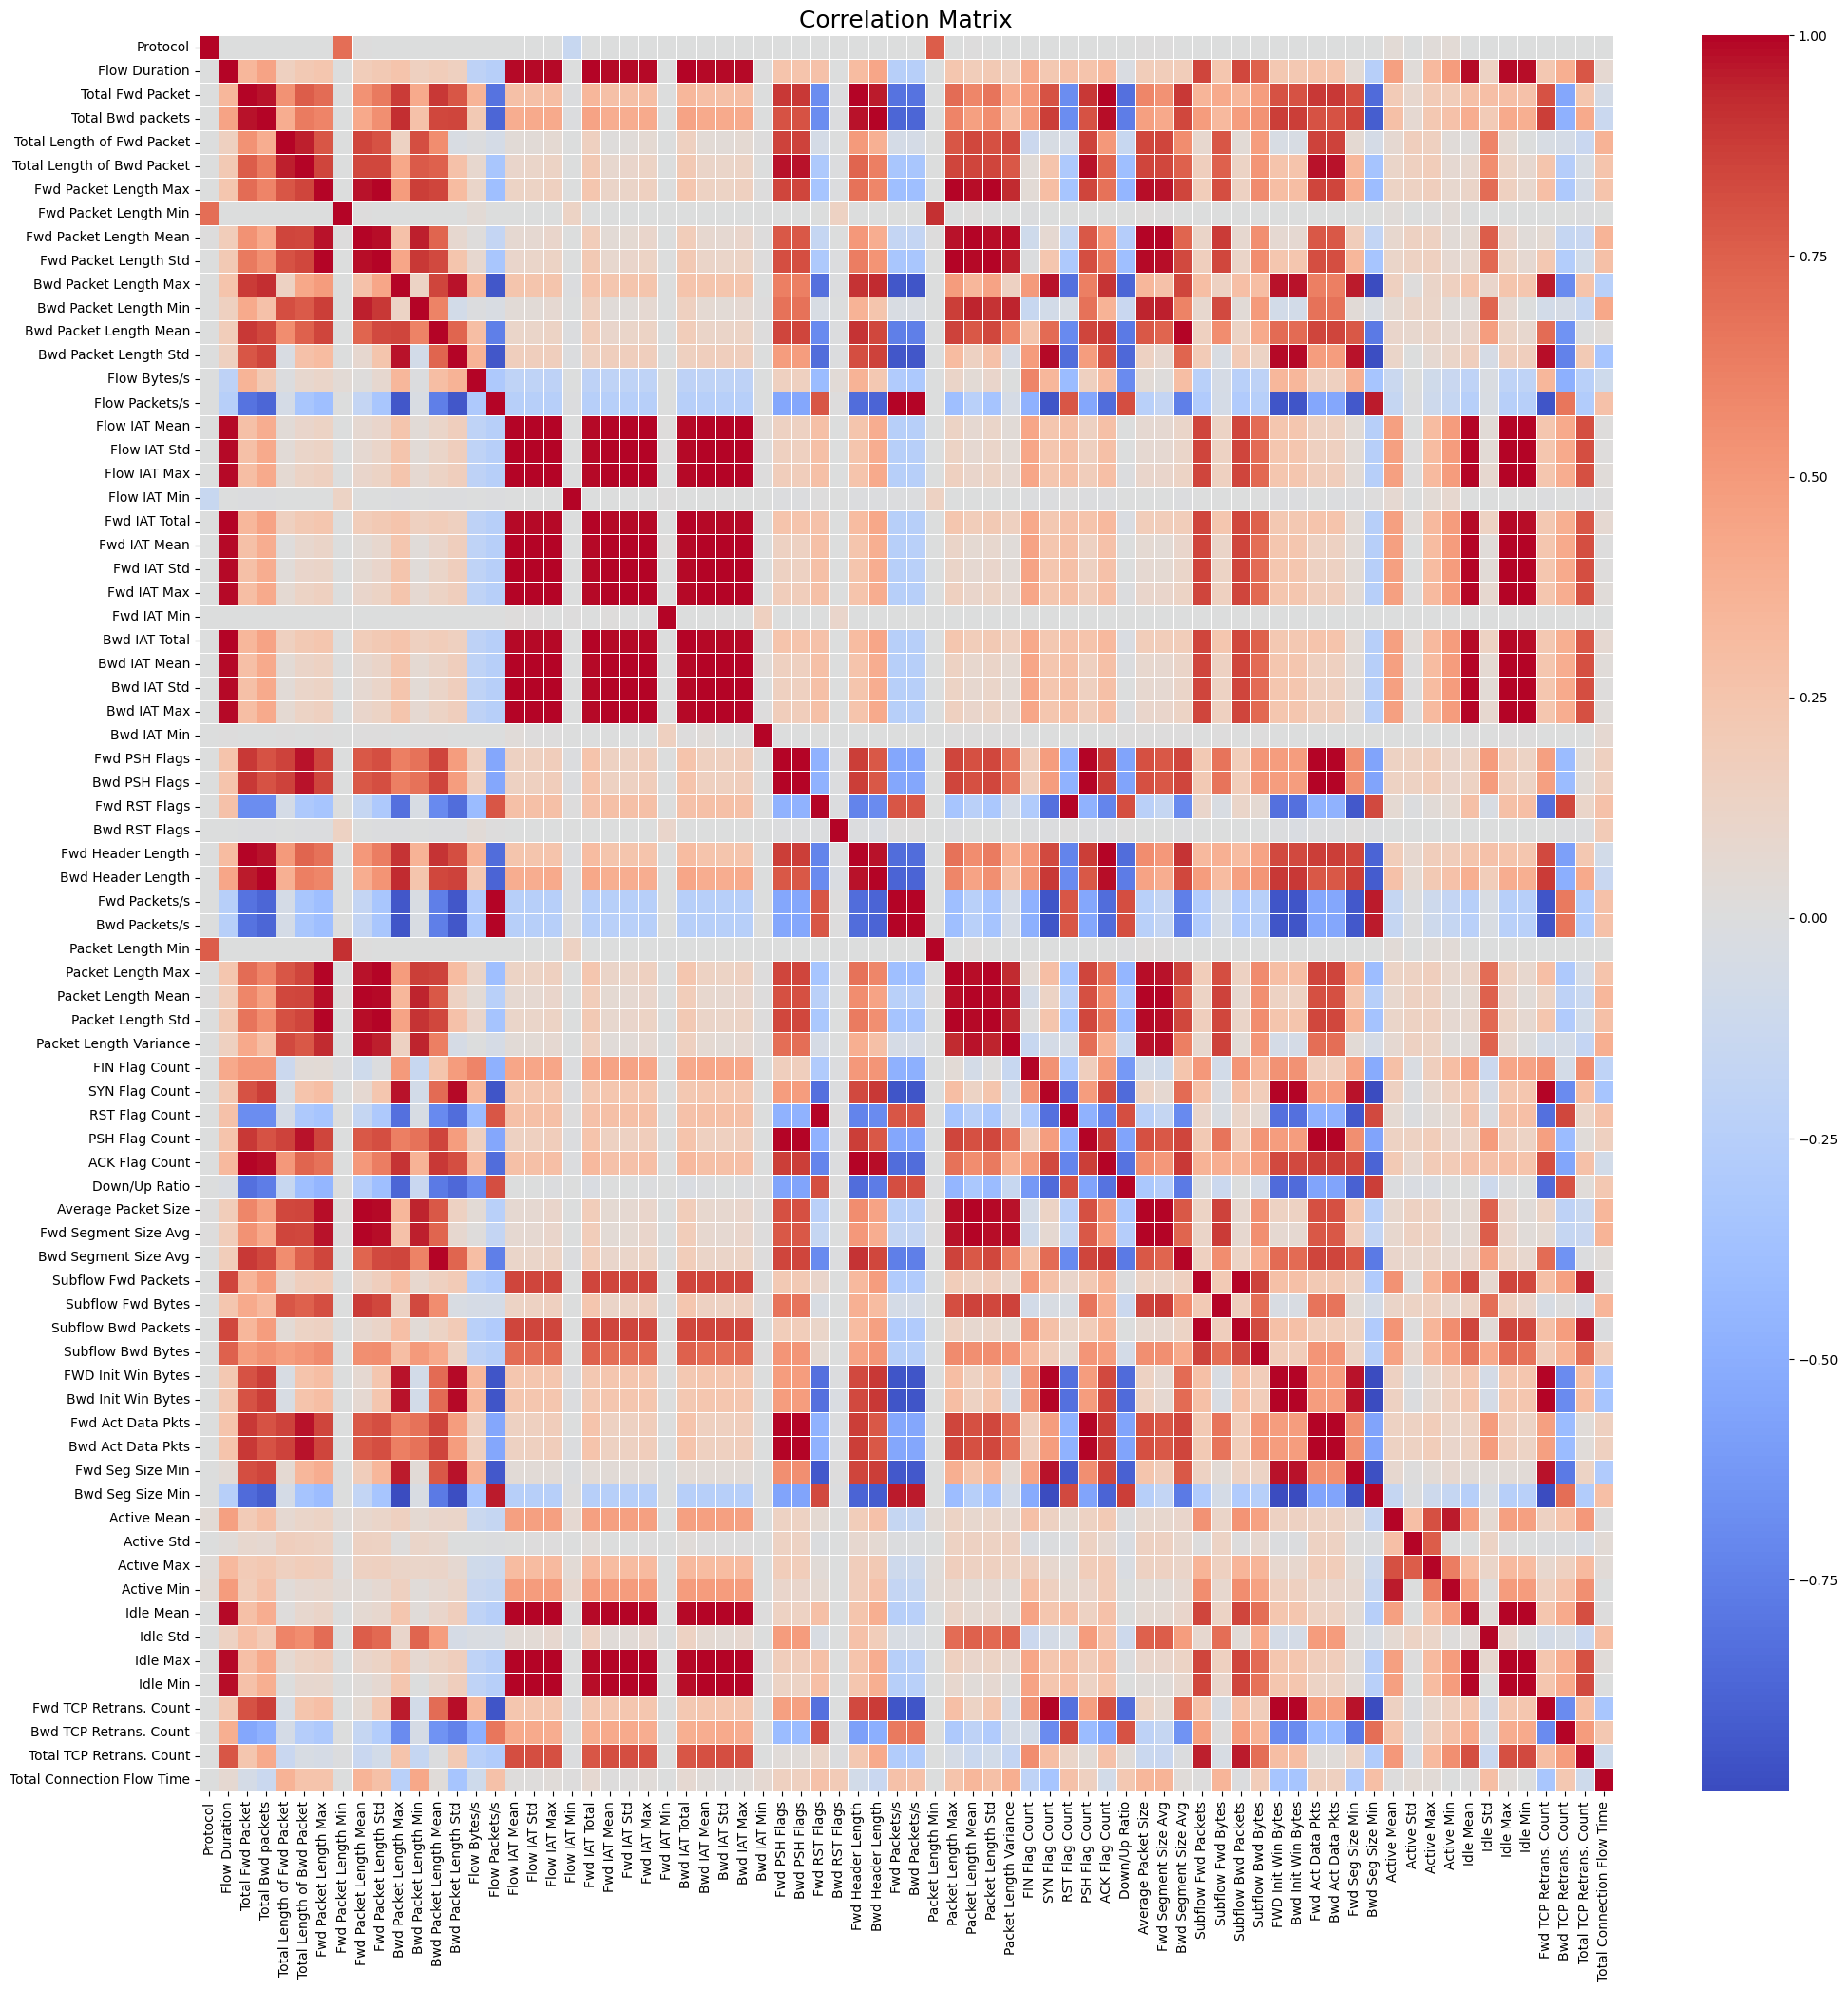

NameError: name 'benign_wide_global_stats' is not defined

In [ ]:
corr = benign_wide_df.corr(numeric_only = True).round(2)
corr.style.background_gradient(cmap = 'coolwarm', axis = None).format(precision = 2)
fig, ax = plt.subplots(figsize = (24, 24))
sns.heatmap(corr, cmap = 'coolwarm', annot = False, linewidth = 0.5)
plt.title('Correlation Matrix', fontsize = 18)
plt.show()
del corr,benign_wide_df


#### Attack dataset Visualization for each Scenario 

In [13]:

###(just for visualization) Uncomment if you want to create the attack plots and statistic tables on your own.

benign_global_stats, benign_label_counts= find_global_stats(modbus.dataset["benign_dataset_dir"] ,"benign",return_fitted_scalers=False)
ext_global_stats, ext_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["external"],"external")
com_ied_global_stats, com_ied_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["compromised-ied"],"compromised-ied")
com_scd_global_stats, com_scd_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["compromised-scada"],"compromised-scada")


---------------------------------------- benign ----------------------------------------
node :  network-wide , file_ 1 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-25-labeled.csv
node :  network-wide , file_ 2 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-30-labeled.csv
node :  network-wide , file_ 3 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-26-labeled.csv
node :  network-wide , file_ 4 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-17-labeled.csv
node :  network-wide , file_ 5 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-18-labeled.csv
node :  network-wide , file_ 6 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-19-labeled.csv
node :  network-w

#### Benign 

-------------------------------------------------------------------------------- 
node_ 0  : network-wide 
flows count_ 2822444.0
                                  mean          std   min            max  \
Protocol                          6.00         0.16  2.00          17.00   
Flow Duration              10297843.17  26824472.17  0.00   119999783.00   
Total Fwd Packet                  4.27         2.50  0.00         226.00   
Total Bwd packets                 3.30         1.65  0.00         210.00   
Total Length of Fwd Packet       17.41       189.83  0.00       52116.00   
Total Length of Bwd Packet        7.97        14.79  0.00        3914.00   
Fwd Packet Length Max             9.21        14.84  0.00         700.00   
Fwd Packet Length Min             0.01         1.08  0.00         118.00   
Fwd Packet Length Mean            1.92         7.00  0.00         230.60   
Fwd Packet Length Std             3.97         7.45  0.00         350.00   
Bwd Packet Length Max             

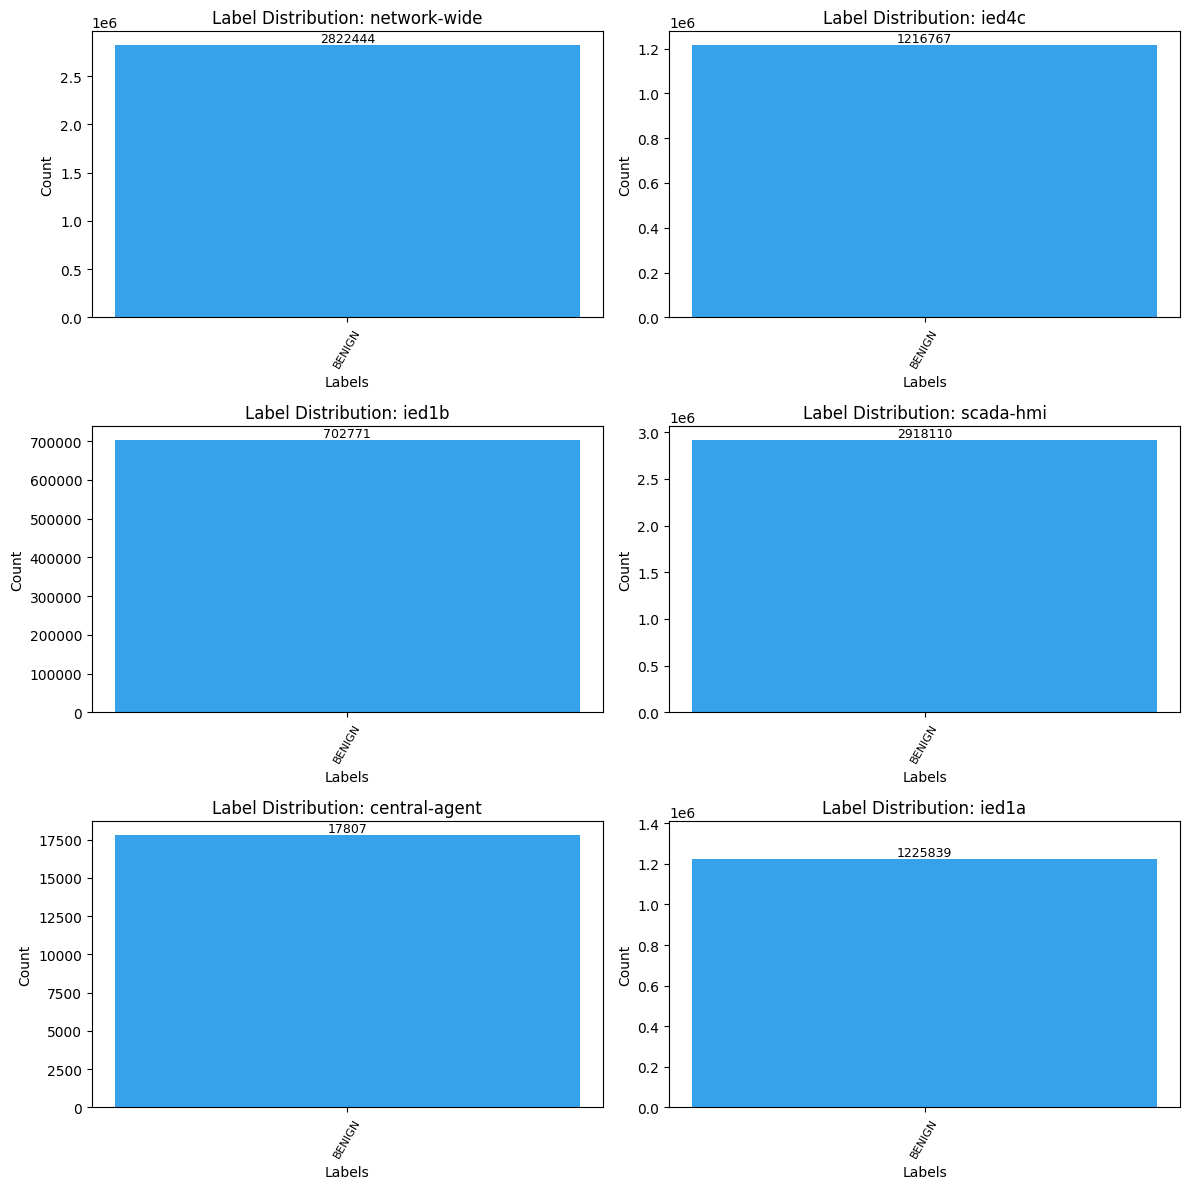

In [14]:

print_statistics(benign_global_stats)
plot_label_counts_subplots(benign_label_counts)


#### Compromised IED

-------------------------------------------------------------------------------- 
node_ 0  : ied4c 
flows count_ 949637.0
                                   mean          std   min            max  \
Protocol                           6.01         0.25  2.00          17.00   
Flow Duration               11306483.16  28013926.62  0.00   119990244.00   
Total Fwd Packet                   3.62         2.57  0.00         118.00   
Total Bwd packets                  2.98         1.79  0.00          61.00   
Total Length of Fwd Packet        18.42       207.76  0.00       15409.00   
Total Length of Bwd Packet         6.97        16.16  0.00        1159.00   
Fwd Packet Length Max              8.11        16.80  0.00         700.00   
Fwd Packet Length Min              0.03         1.71  0.00         118.00   
Fwd Packet Length Mean             1.89         8.33  0.00         175.00   
Fwd Packet Length Std              3.60         8.49  0.00         350.00   
Bwd Packet Length Max          

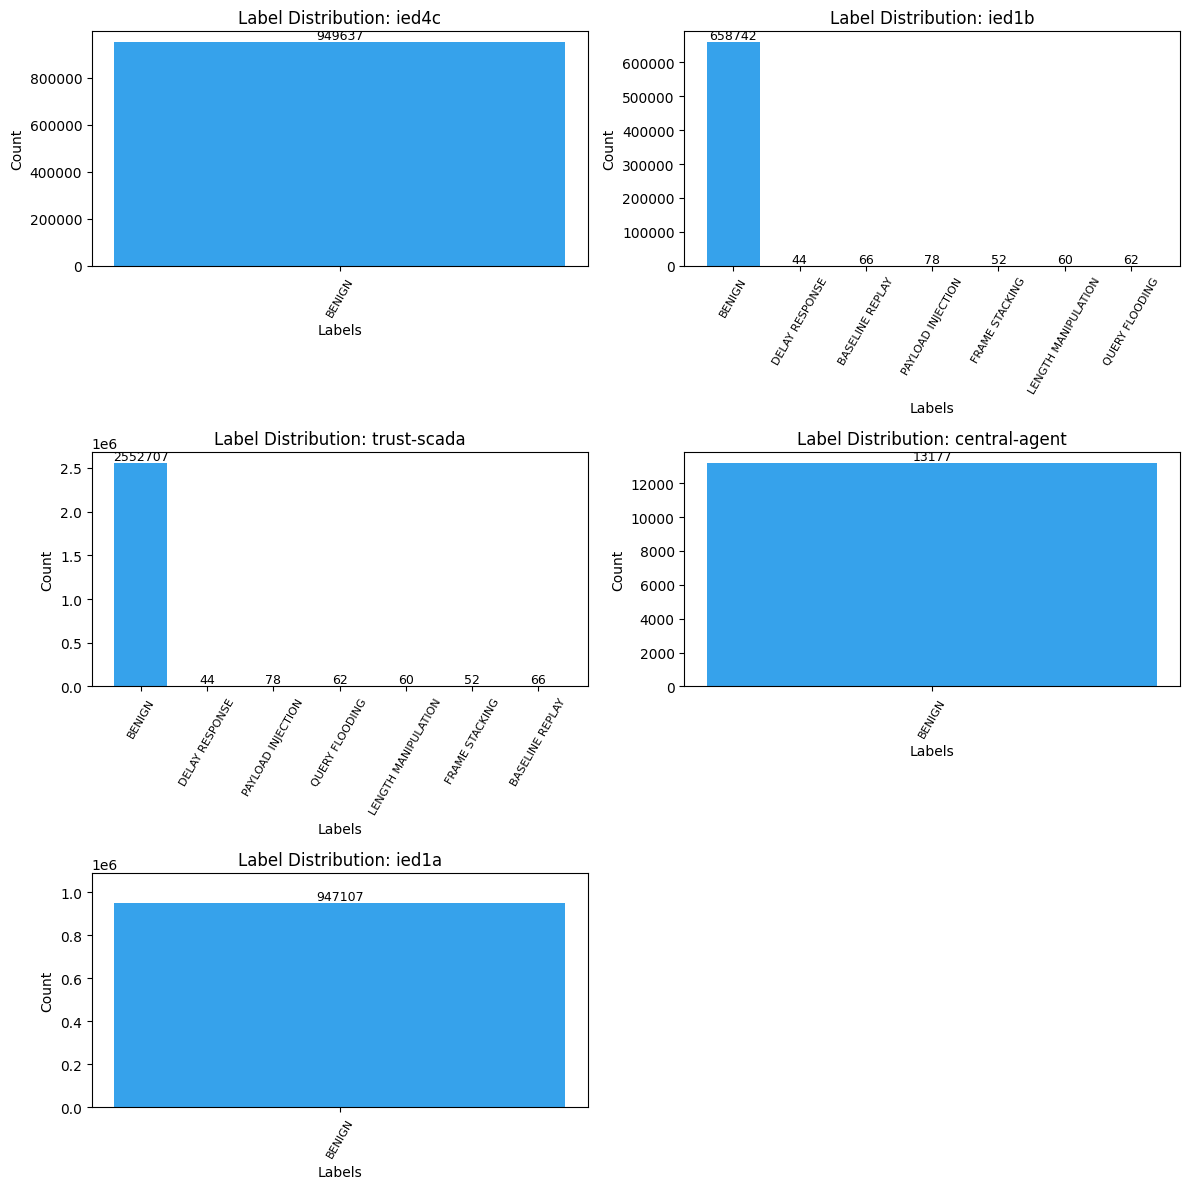

In [15]:

print_statistics(com_ied_global_stats)
plot_label_counts_subplots(com_ied_label_counts)


#### Compromised SCADA

-------------------------------------------------------------------------------- 
node_ 0  : ied4c 
flows count_ 839426.0
                                   mean           std   min             max  \
Protocol                           6.01          0.27  2.00           17.00   
Flow Duration               10097713.06   25868605.09  0.00    119999661.00   
Total Fwd Packet                   3.90          5.57  0.00          182.00   
Total Bwd packets                  3.14          3.12  0.00           99.00   
Total Length of Fwd Packet        46.01        711.73  0.00        25021.00   
Total Length of Bwd Packet         8.15         53.48  0.00         1881.00   
Fwd Packet Length Max              8.55         16.99  0.00          718.00   
Fwd Packet Length Min              0.04          1.88  0.00          118.00   
Fwd Packet Length Mean             2.04          8.51  0.00          179.50   
Fwd Packet Length Std              3.83          8.40  0.00          359.00   
Bwd Packe

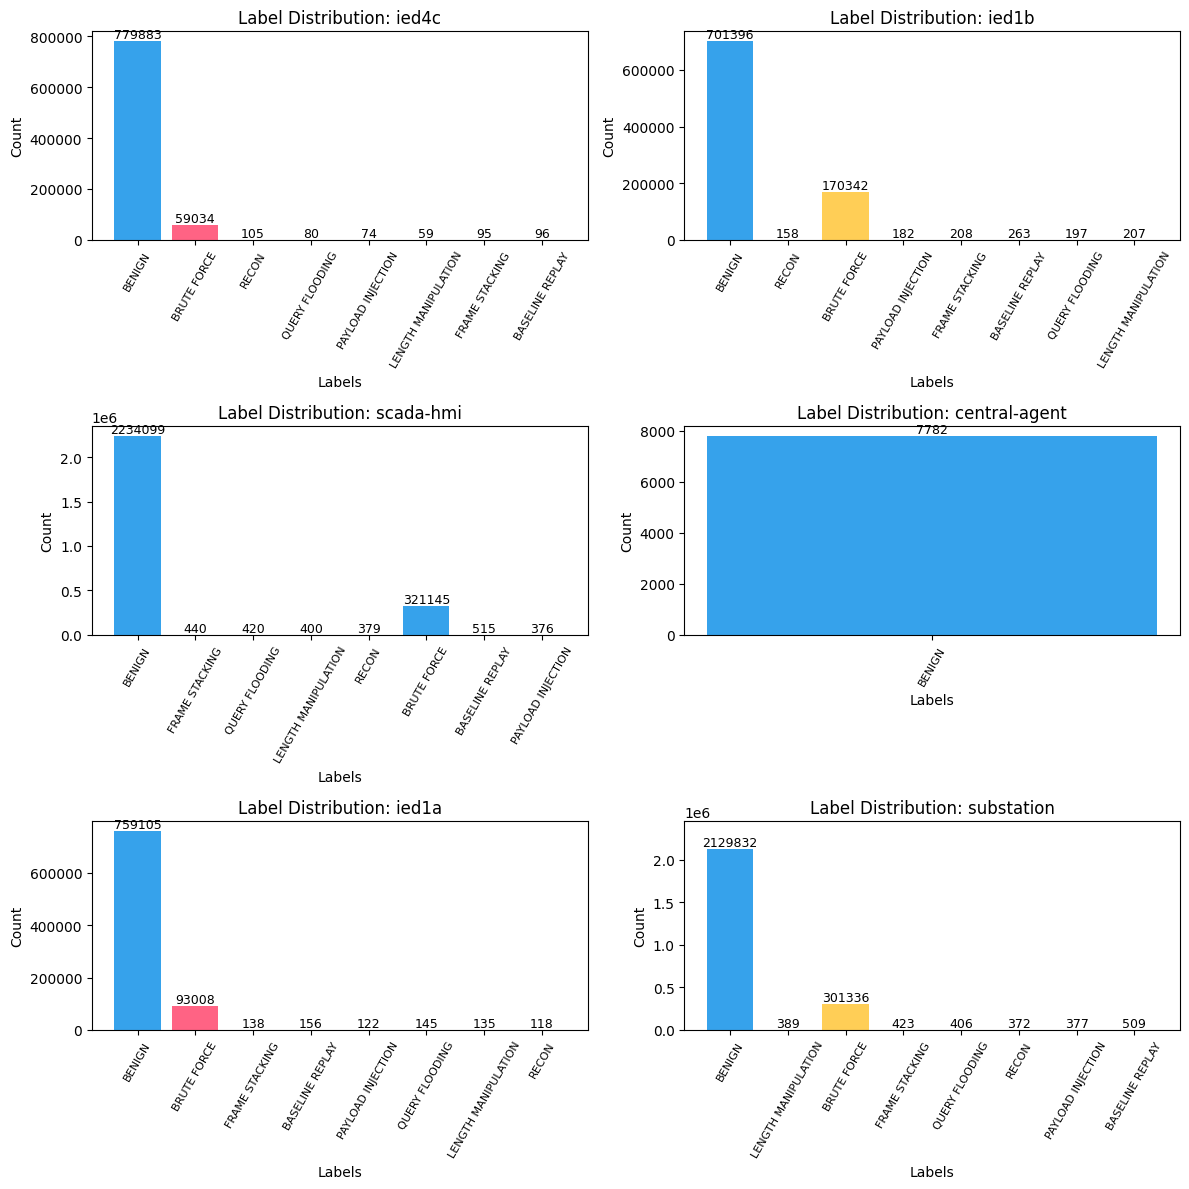

In [16]:

print_statistics(com_scd_global_stats)
plot_label_counts_subplots(com_scd_label_counts)


#### Ensure correct  Shuffling and Min Max interval after scaling [0 to 1]

##### The Analysis are on ied1b node dataset (compromised-scada scenario) because of having enough samples for diverse Categories

In [6]:
### for test performance of the machine learning algorithms on all attack categories (except Delay Response) 
### ied1b node of the compromised-scada scenario is suitable
csv_files=[col for col in modbus.dataset["attack_dataset_dir"]["compromised-scada"] if col.find("ied1b")!=-1]
print("ied1b number of csv files :",len(csv_files),csv_files)

dataset = CSVDataset(csv_files=csv_files, chunk_size=1, scalers=benign_scalers["network-wide"]["min_max_scalers"])
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
print(f"Total batches in the dataset: {len(dataloader)}")
num_epochs = 3 # Example: Train for 3 epochs
start_time =time.time()
for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch + 1}/{num_epochs} ---")

    start_time =time.time()
    for batch_idx, (features, labels) in enumerate(dataloader):
        # 'features' will be a tensor of shape (batch_size, num_features)
        # 'labels' will be a tensor of shape (batch_size,)
        # Where batch_size is 64 (or less for the final batch in a chunk/dataset)

        print(f"  Batch {batch_idx + 1}: Features {features[0][0] }, Labels shape={labels.shape}")
        time.sleep(0.001)
        break

    print(f"Elapsed time: {(time.time() - start_time) * 1000:.2f} ms")


ied1b number of csv files : 8 ['./dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-6-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-3-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-4-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-1-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-7-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-0-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-5-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-2-labeled.csv']
Total batches in the dataset: 13640

--- Epoch 1/3 ---
  Batch 1:

#### Multi-class Classification with the Classic Machine Learning 

##### Machine learning models Used

- Gaussian Naive Bayes (GaussianNB)
- Random Forest
- Decision Tree
- Gradient Boosting
- linear SVM
- Logistic Regression
- KNN

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import random

# Function to plot the confusion matrix heatmap
def plot_confusion_matrix(y_true, y_pred, label_encoder, title="Confusion Matrix"):
    """
    Plots a confusion matrix as a heatmap.

    Args:
        y_true (np.ndarray): True labels.
        y_pred (np.ndarray): Predicted labels.
        label_encoder (LabelEncoder): The fitted LabelEncoder.
        title (str): Title for the plot.
    """
    # Get all possible encoded classes to ensure the matrix is square and complete
    all_classes_encoded = np.arange(len(label_encoder.classes_))
    cm = confusion_matrix(y_true, y_pred, labels=all_classes_encoded)
    
    # Get the original label names for ticks
    class_names = label_encoder.inverse_transform(all_classes_encoded)

    # Normalize the confusion matrix for better interpretability (optional)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized) # Replace NaNs (from divisions by zero) with 0

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized,
        annot=True,      # Annotate cells with values
        fmt=".2f",       # Format annotations to 2 decimal places
        cmap="Blues",    # Color map
        cbar=True,       # Show color bar
        xticklabels=class_names, # X-axis labels (predicted)
        yticklabels=class_names  # Y-axis labels (true)
    )
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
    plt.yticks(rotation=0)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

# Extract data and labels
def np_from_dataloader(_dataloader):
    data_list = []
    labels_list = []
    for batch_x, batch_y in _dataloader:
        data_list.append(batch_x.numpy())
        labels_list.append(batch_y.numpy())
    # Convert lists to NumPy arrays
    X_np = np.concatenate(data_list, axis=1)
    y_np = np.concatenate(labels_list, axis=1)
    return X_np.squeeze(0),y_np.squeeze(0)


def train_evaluate(base_models,features,labels,label_encoder,val_ratio=0.25,shuffle=False):
    
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size = val_ratio, random_state = 0,shuffle=shuffle)
    
    train_unique_labels, train_counts = np.unique(y_train, return_counts=True)
    valid_unique_labels, valid_counts = np.unique(y_val, return_counts=True)

    ## no delay response attack in the compromised ied scenario
    print("train_dataset unbalanced label distribution before sampling")
    for i in range(len(train_unique_labels)):
        print(f"Label {train_unique_labels[i]}: {train_counts[i]} ")
    print("-" * 30)
    print("valid_dataset unbalanced label distribution before sampling")
    for i in range(len(valid_unique_labels)):
        print(f"Label {valid_unique_labels[i]}: {valid_counts[i]} ")
    print("-" * 30)
    time.sleep(5)
    for i, model in enumerate(base_models):
        
        print(f"\n--- Training Base Model {i+1} ---{model}")
        model.fit(X_train, y_train)
        
        print(f"--- Evaluating Base Model {i+1} ---{model} on Validation Set ---")
        y_pred = model.predict(X_val)
        
        print(f"Accuracy of Base Model {i+1}: ---{model}  {accuracy_score(y_val, y_pred):.4f}")
        
        #ensures that all 9 classes are considered, even if some are missing in y_val/y_pred
        print(classification_report(y_val, y_pred, 
                                    labels=np.arange(len(label_encoder.classes_)), 
                                    target_names=list(label_encoder.classes_), 
                                    zero_division=np.nan))
        # Plotting the confusion matrix heatmap
        plot_confusion_matrix(y_val, y_pred, label_encoder, 
                            title=f"Confusion Matrix for Base Model {i+1} ---{model} ")




In [8]:

base_models = [
    LogisticRegression(random_state=0,max_iter=200),
    LinearSVC( random_state=0,max_iter=200),
    GaussianNB(),
    RandomForestClassifier(n_estimators=50, random_state=0),
    DecisionTreeClassifier(random_state=0,criterion='gini'),
    DecisionTreeClassifier(random_state=0,criterion='entropy'),
    KNeighborsClassifier(n_neighbors=3),
    HistGradientBoostingClassifier( learning_rate=0.1, random_state=0,max_iter=200)
]

shuffle=False
random_seed =42
train_ratio=0.5
valid_ratio = 1-train_ratio
csv_files=[col for col in modbus.dataset["attack_dataset_dir"]["compromised-scada"] if col.find("ied1b")!=-1]
csv_files2 = csv_files[0:4]
# Set random seed if shuffling
if shuffle:
    random.seed(random_seed)
    random.shuffle(csv_files2)

print(len(csv_files2),csv_files2)


4 ['./dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-6-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-3-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-4-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-1-labeled.csv']


In [11]:
# Initialize datasets without scale
train_dataset = CSVDataset(
    csv_files=csv_files2,chunk_size=1,shuffle=False
)
train_dataloader =DataLoader(train_dataset, batch_size=1, shuffle=False)

X_train , y_train = np_from_dataloader(train_dataloader)

_unique_labels, _counts = np.unique(y_train, return_counts=True)

## no delay response attack in the compromised ied scenario
print("train_dataset unbalanced label distribution before sampling")
for i in range(len(_unique_labels)):
    print(f"Label {_unique_labels[i]}: {_counts[i]} ")
print("-" * 30)

train_dataset unbalanced label distribution before sampling
Label 0: 178 
Label 1: 383629 
Label 2: 105690 
Label 4: 125 
Label 5: 108 
Label 6: 101 
Label 7: 118 
Label 8: 86 
------------------------------


#### Training and Evaluation Loop 


train_dataset unbalanced label distribution before sampling
Label 0: 133 
Label 1: 297934 
Label 2: 69112 
Label 4: 101 
Label 5: 56 
Label 6: 62 
Label 7: 74 
Label 8: 54 
------------------------------
valid_dataset unbalanced label distribution before sampling
Label 0: 45 
Label 1: 85695 
Label 2: 36578 
Label 4: 24 
Label 5: 52 
Label 6: 39 
Label 7: 44 
Label 8: 32 
------------------------------

--- Training Base Model 1 ---LogisticRegression(max_iter=200, random_state=0)


/home/hamid_rd3/labeling/Project1404/vnv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_24952/1981710367.py:30: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


--- Evaluating Base Model 1 ---LogisticRegression(max_iter=200, random_state=0) on Validation Set ---
Accuracy of Base Model 1: ---LogisticRegression(max_iter=200, random_state=0)  0.9023
                     precision    recall  f1-score   support

    BASELINE REPLAY        nan      0.00      0.00        45
             BENIGN       0.88      1.00      0.94     85695
        BRUTE FORCE       0.99      0.68      0.81     36578
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       0.59      0.42      0.49        24
LENGTH MANIPULATION        nan      0.00      0.00        52
  PAYLOAD INJECTION        nan      0.00      0.00        39
     QUERY FLOODING       1.00      0.34      0.51        44
              RECON        nan      0.00      0.00        32

           accuracy                           0.90    122509
          macro avg       0.86      0.30      0.34    122509
       weighted avg       0.91      0.90      0.90    122509



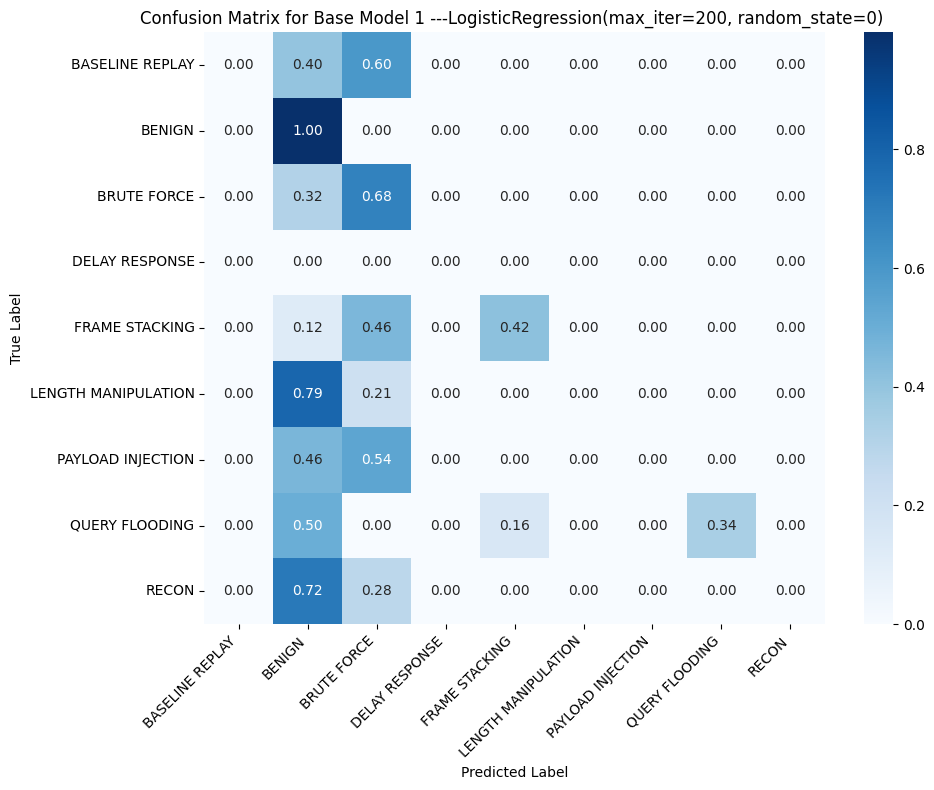


--- Training Base Model 2 ---LinearSVC(max_iter=200, random_state=0)


/home/hamid_rd3/labeling/Project1404/vnv/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/tmp/ipykernel_24952/1981710367.py:30: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


--- Evaluating Base Model 2 ---LinearSVC(max_iter=200, random_state=0) on Validation Set ---
Accuracy of Base Model 2: ---LinearSVC(max_iter=200, random_state=0)  0.9377
                     precision    recall  f1-score   support

    BASELINE REPLAY        nan      0.00      0.00        45
             BENIGN       0.92      1.00      0.96     85695
        BRUTE FORCE       0.99      0.80      0.89     36578
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       0.40      0.08      0.14        24
LENGTH MANIPULATION       0.00      0.00      0.00        52
  PAYLOAD INJECTION        nan      0.00      0.00        39
     QUERY FLOODING       1.00      0.30      0.46        44
              RECON        nan      0.00      0.00        32

           accuracy                           0.94    122509
          macro avg       0.66      0.27      0.30    122509
       weighted avg       0.94      0.94      0.93    122509



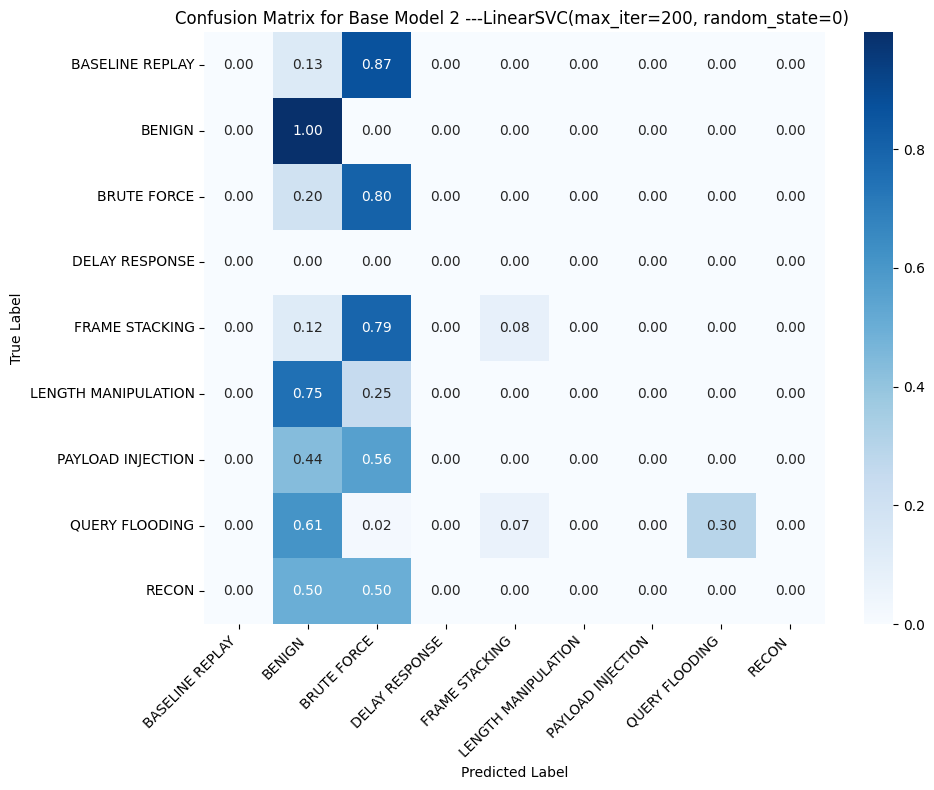


--- Training Base Model 3 ---GaussianNB()
--- Evaluating Base Model 3 ---GaussianNB() on Validation Set ---
Accuracy of Base Model 3: ---GaussianNB()  0.0044
                     precision    recall  f1-score   support

    BASELINE REPLAY       0.00      0.00      0.00        45
             BENIGN       0.76      0.01      0.01     85695
        BRUTE FORCE       0.00      0.00      0.00     36578
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       0.01      0.12      0.01        24
LENGTH MANIPULATION       0.00      0.19      0.00        52
  PAYLOAD INJECTION       0.00      0.56      0.00        39
     QUERY FLOODING       0.39      1.00      0.56        44
              RECON       0.00      0.28      0.00        32

           accuracy                           0.00    122509
          macro avg       0.14      0.27      0.07    122509
       weighted avg       0.53      0.00      0.01    122509



/tmp/ipykernel_24952/1981710367.py:30: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


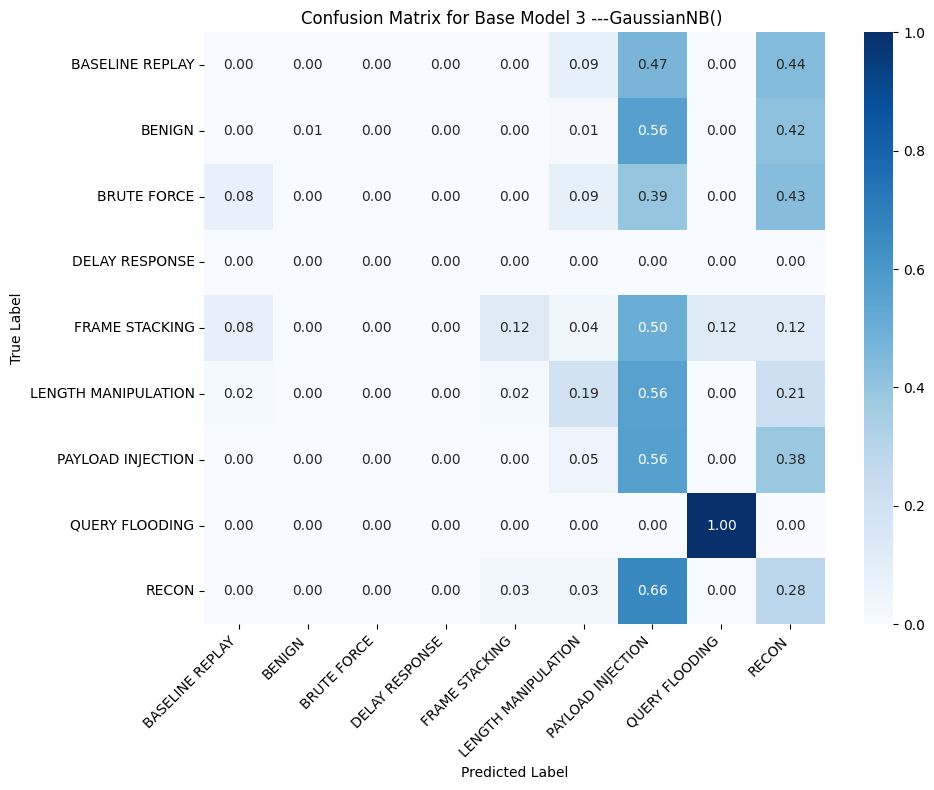


--- Training Base Model 4 ---RandomForestClassifier(n_estimators=50, random_state=0)
--- Evaluating Base Model 4 ---RandomForestClassifier(n_estimators=50, random_state=0) on Validation Set ---
Accuracy of Base Model 4: ---RandomForestClassifier(n_estimators=50, random_state=0)  0.9021
                     precision    recall  f1-score   support

    BASELINE REPLAY       0.83      0.42      0.56        45
             BENIGN       0.88      1.00      0.93     85695
        BRUTE FORCE       0.99      0.68      0.81     36578
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       1.00      0.75      0.86        24
LENGTH MANIPULATION       1.00      0.71      0.83        52
  PAYLOAD INJECTION       1.00      0.56      0.72        39
     QUERY FLOODING       1.00      0.59      0.74        44
              RECON        nan      0.00      0.00        32

           accuracy                           0.90    122509
          macro avg       0.96      0.5

/tmp/ipykernel_24952/1981710367.py:30: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


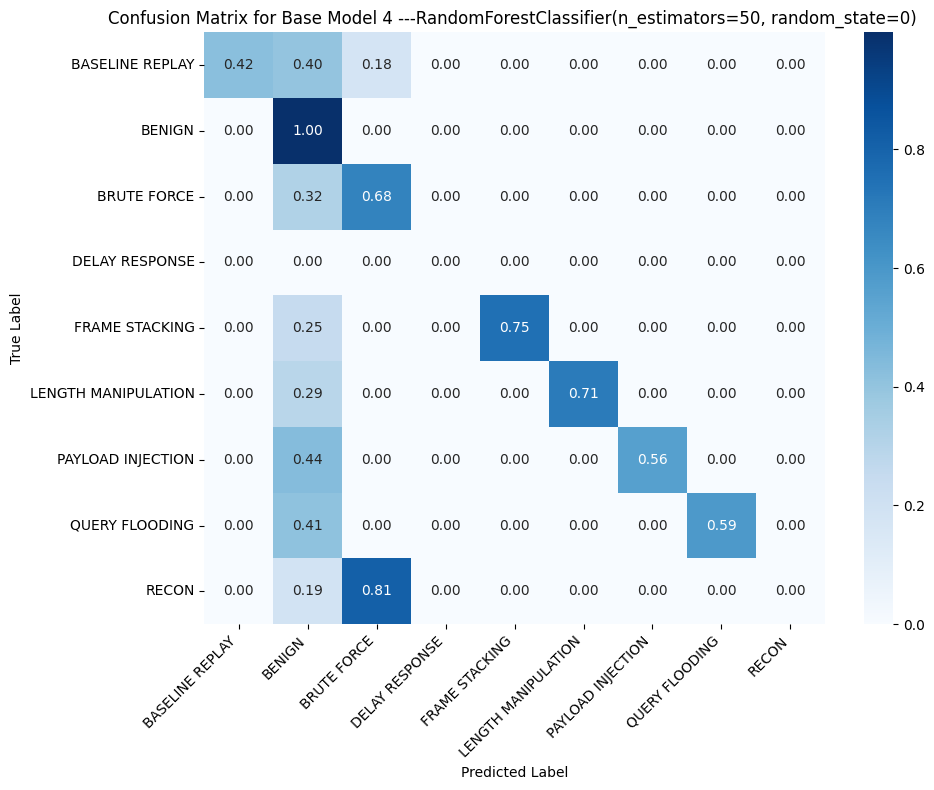


--- Training Base Model 5 ---DecisionTreeClassifier(random_state=0)
--- Evaluating Base Model 5 ---DecisionTreeClassifier(random_state=0) on Validation Set ---
Accuracy of Base Model 5: ---DecisionTreeClassifier(random_state=0)  0.8784
                     precision    recall  f1-score   support

    BASELINE REPLAY       0.73      0.36      0.48        45
             BENIGN       0.85      1.00      0.92     85695
        BRUTE FORCE       0.98      0.60      0.75     36578
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       1.00      0.79      0.88        24
LENGTH MANIPULATION       0.97      0.71      0.82        52
  PAYLOAD INJECTION       1.00      0.56      0.72        39
     QUERY FLOODING       1.00      0.50      0.67        44
              RECON       0.00      0.00      0.00        32

           accuracy                           0.88    122509
          macro avg       0.82      0.57      0.66    122509
       weighted avg       0.8

/tmp/ipykernel_24952/1981710367.py:30: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


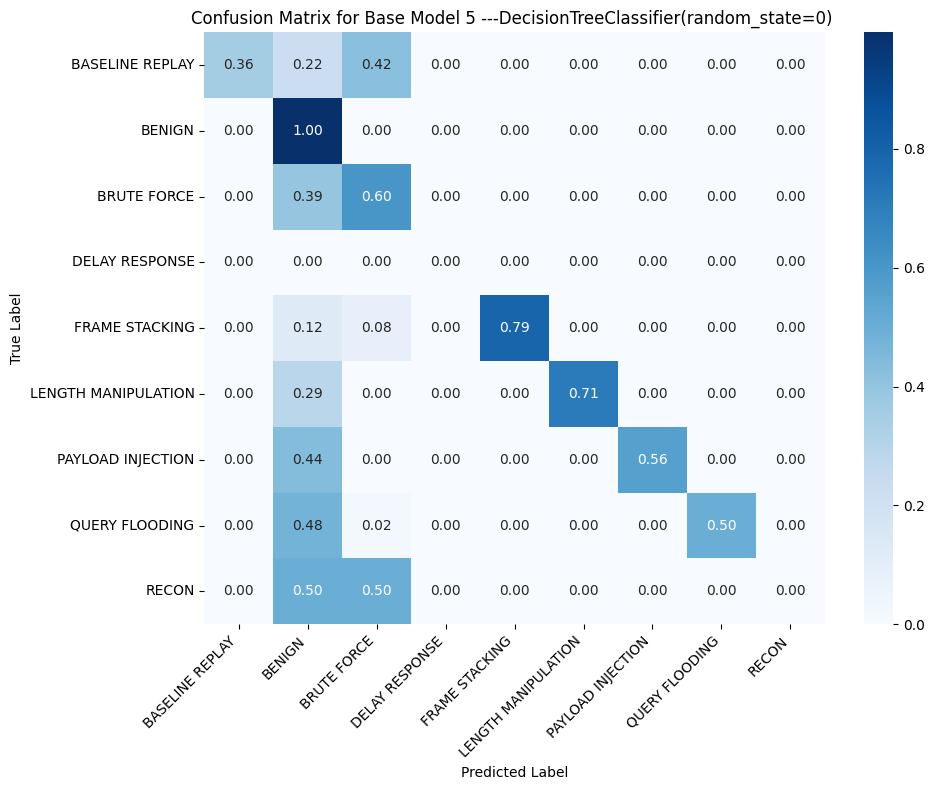


--- Training Base Model 6 ---DecisionTreeClassifier(criterion='entropy', random_state=0)
--- Evaluating Base Model 6 ---DecisionTreeClassifier(criterion='entropy', random_state=0) on Validation Set ---
Accuracy of Base Model 6: ---DecisionTreeClassifier(criterion='entropy', random_state=0)  0.8789
                     precision    recall  f1-score   support

    BASELINE REPLAY       0.61      0.51      0.55        45
             BENIGN       0.85      1.00      0.92     85695
        BRUTE FORCE       0.99      0.61      0.75     36578
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       0.94      0.71      0.81        24
LENGTH MANIPULATION       0.97      0.60      0.74        52
  PAYLOAD INJECTION       1.00      0.44      0.61        39
     QUERY FLOODING       1.00      0.55      0.71        44
              RECON       0.00      0.00      0.00        32

           accuracy                           0.88    122509
          macro avg       0

/tmp/ipykernel_24952/1981710367.py:30: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


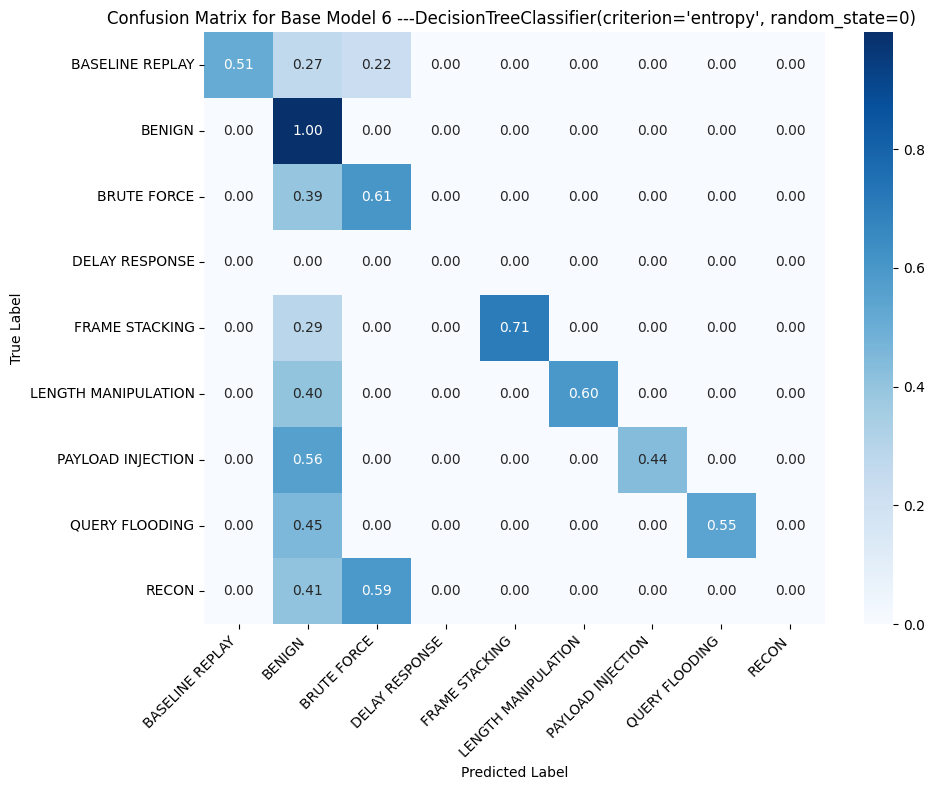


--- Training Base Model 7 ---KNeighborsClassifier(n_neighbors=3)
--- Evaluating Base Model 7 ---KNeighborsClassifier(n_neighbors=3) on Validation Set ---
Accuracy of Base Model 7: ---KNeighborsClassifier(n_neighbors=3)  0.8934
                     precision    recall  f1-score   support

    BASELINE REPLAY       0.53      0.18      0.27        45
             BENIGN       0.87      1.00      0.93     85695
        BRUTE FORCE       0.99      0.65      0.79     36578
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       0.83      0.79      0.81        24
LENGTH MANIPULATION       0.96      0.52      0.68        52
  PAYLOAD INJECTION       0.75      0.15      0.26        39
     QUERY FLOODING       1.00      0.48      0.65        44
              RECON        nan      0.00      0.00        32

           accuracy                           0.89    122509
          macro avg       0.85      0.47      0.55    122509
       weighted avg       0.91      0.

/tmp/ipykernel_24952/1981710367.py:30: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


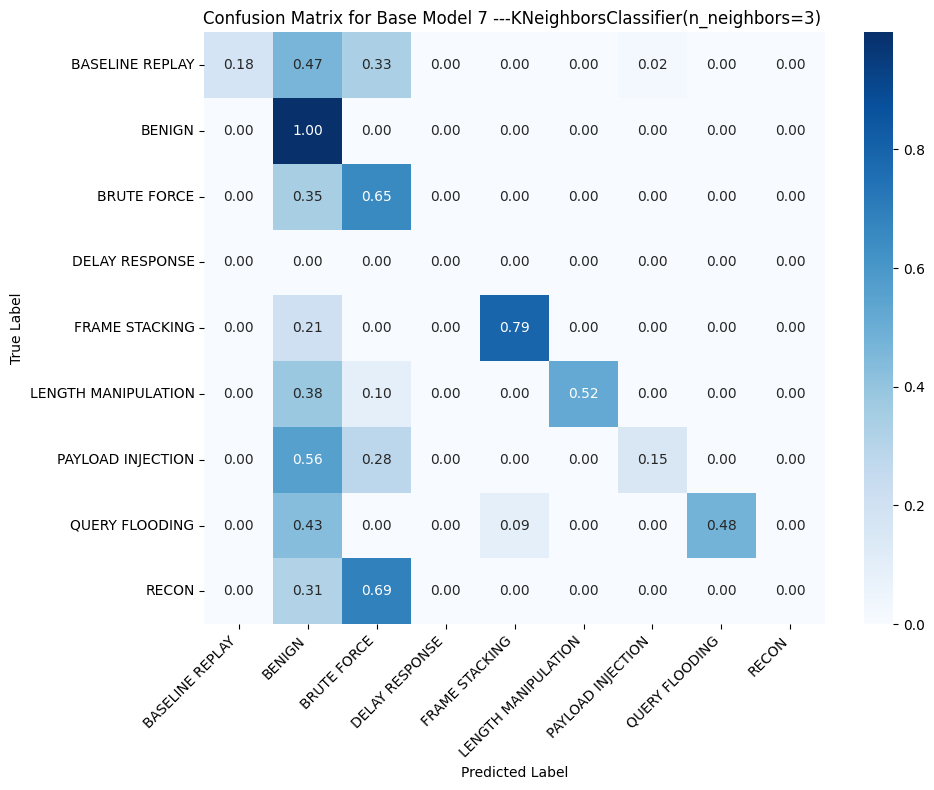


--- Training Base Model 8 ---HistGradientBoostingClassifier(max_iter=200, random_state=0)
--- Evaluating Base Model 8 ---HistGradientBoostingClassifier(max_iter=200, random_state=0) on Validation Set ---
Accuracy of Base Model 8: ---HistGradientBoostingClassifier(max_iter=200, random_state=0)  0.9543
                     precision    recall  f1-score   support

    BASELINE REPLAY       0.08      0.16      0.10        45
             BENIGN       0.95      1.00      0.97     85695
        BRUTE FORCE       0.99      0.86      0.92     36578
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       0.12      0.62      0.21        24
LENGTH MANIPULATION       0.61      1.00      0.76        52
  PAYLOAD INJECTION       0.19      0.44      0.26        39
     QUERY FLOODING       0.61      0.68      0.65        44
              RECON       0.00      0.00      0.00        32

           accuracy                           0.95    122509
          macro avg     

/tmp/ipykernel_24952/1981710367.py:30: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


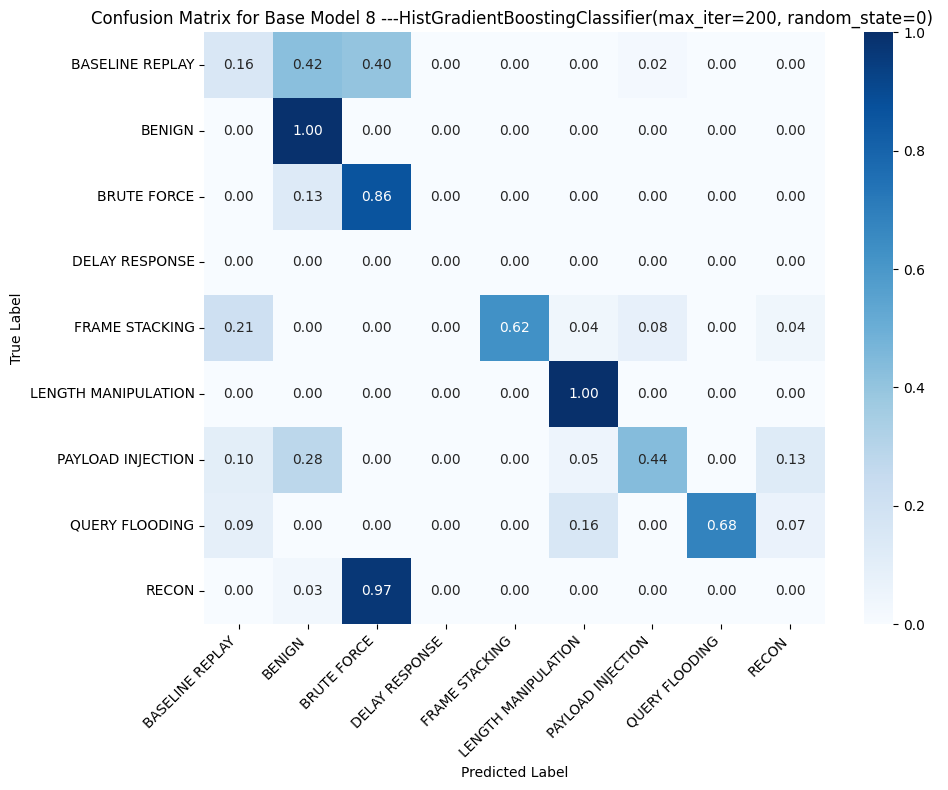

In [9]:
### Train on the original data distribution (without scale,sampling techniques and drop zero variance columns)
train_evaluate(base_models,X_train,y_train,train_dataset.label_encoder,val_ratio=0.25)

#### Creating a Balanced Dataset 



In [18]:
# Initialize datasets without scale
train_dataset = CSVDataset(
    csv_files=csv_files2,chunk_size=1,shuffle=False,
    unuseful_features=['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp','end_time',
                       'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count', 'CWR Flag Count', 'ECE Flag Count',
                         'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg',
                           'Bwd Packet/Bulk Avg', 'Bwd Bulk Rate Avg', 'ICMP Code', 'ICMP Type']
)
train_dataloader =DataLoader(train_dataset, batch_size=1, shuffle=False)

### add min max scaler
train_dataset.scalers=benign_scalers["network-wide"]["min_max_scalers"]
### drop zero variance (concluded by the network-wide node benign before)
train_dataset.unuseful_features.extend(['Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count', 'CWR Flag Count', 'ECE Flag Count', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg', 'Bwd Packet/Bulk Avg', 'Bwd Bulk Rate Avg', 'ICMP Code', 'ICMP Type'])
print(train_dataset.unuseful_features)
train_dataloader =DataLoader(train_dataset, batch_size=1, shuffle=False)
X_train , y_train = np_from_dataloader(train_dataloader)



['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp', 'end_time', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count', 'CWR Flag Count', 'ECE Flag Count', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg', 'Bwd Packet/Bulk Avg', 'Bwd Bulk Rate Avg', 'ICMP Code', 'ICMP Type', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count', 'CWR Flag Count', 'ECE Flag Count', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg', 'Bwd Packet/Bulk Avg', 'Bwd Bulk Rate Avg', 'ICMP Code', 'ICMP Type']


In [ ]:
### no balanced dataset, just MinMaxScale and remove zero var features
train_evaluate(base_models,X_train,y_train,train_dataset.label_encoder,shuffle=False)

In [ ]:

sampling_strategy_rus = {
    0: 178,    
    1: 1000,  # Downsample from 383629 to 1000
    2: 1000, # Downsample from 105690 to 1000
    4: 125, 
    5: 108, 
    6: 101, 
    7: 118, 
    8: 86    
}
rus = RandomUnderSampler(sampling_strategy=sampling_strategy_rus, random_state=42)
X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)
print("\nDistribution after RandomUnderSampler:")
print(dict(Counter(y_resampled_rus)))
print(f"Resampled X_train shape (RUS): {X_resampled_rus.shape}")
print(f"Resampled y_train shape (RUS): {y_resampled_rus.shape}")
print("-" * 50)

smote = SMOTE(sampling_strategy='auto', random_state=0)
X_upsampled, y_upsampled = smote.fit_resample(X_resampled_rus, y_resampled_rus)

print("\nDistribution after SMOTE OverSampler:")
print(dict(Counter(y_upsampled)))
print(f"Resampled X_train shape (RUS): {X_upsampled.shape}")
print(f"Resampled y_train shape (RUS): {y_upsampled.shape}")
print("-" * 50)



train_dataset unbalanced label distribution before sampling
Label 0: 739 
Label 1: 756 
Label 2: 765 
Label 4: 746 
Label 5: 771 
Label 6: 740 
Label 7: 750 
Label 8: 733 
------------------------------
valid_dataset unbalanced label distribution before sampling
Label 0: 261 
Label 1: 244 
Label 2: 235 
Label 4: 254 
Label 5: 229 
Label 6: 260 
Label 7: 250 
Label 8: 267 
------------------------------

--- Training Base Model 1 ---LogisticRegression(max_iter=200, random_state=0)


/home/hamid_rd3/labeling/Project1404/vnv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_31880/2362505150.py:30: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


--- Evaluating Base Model 1 ---LogisticRegression(max_iter=200, random_state=0) on Validation Set ---
Accuracy of Base Model 1: ---LogisticRegression(max_iter=200, random_state=0)  0.4450
                     precision    recall  f1-score   support

    BASELINE REPLAY       0.27      0.84      0.41       261
             BENIGN       1.00      0.31      0.47       244
        BRUTE FORCE       1.00      0.01      0.02       235
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       0.95      0.54      0.69       254
LENGTH MANIPULATION       0.30      1.00      0.47       229
  PAYLOAD INJECTION        nan      0.00      0.00       260
     QUERY FLOODING       1.00      0.87      0.93       250
              RECON       0.92      0.04      0.09       267

           accuracy                           0.45      2000
          macro avg       0.78      0.45      0.38      2000
       weighted avg       0.78      0.45      0.38      2000



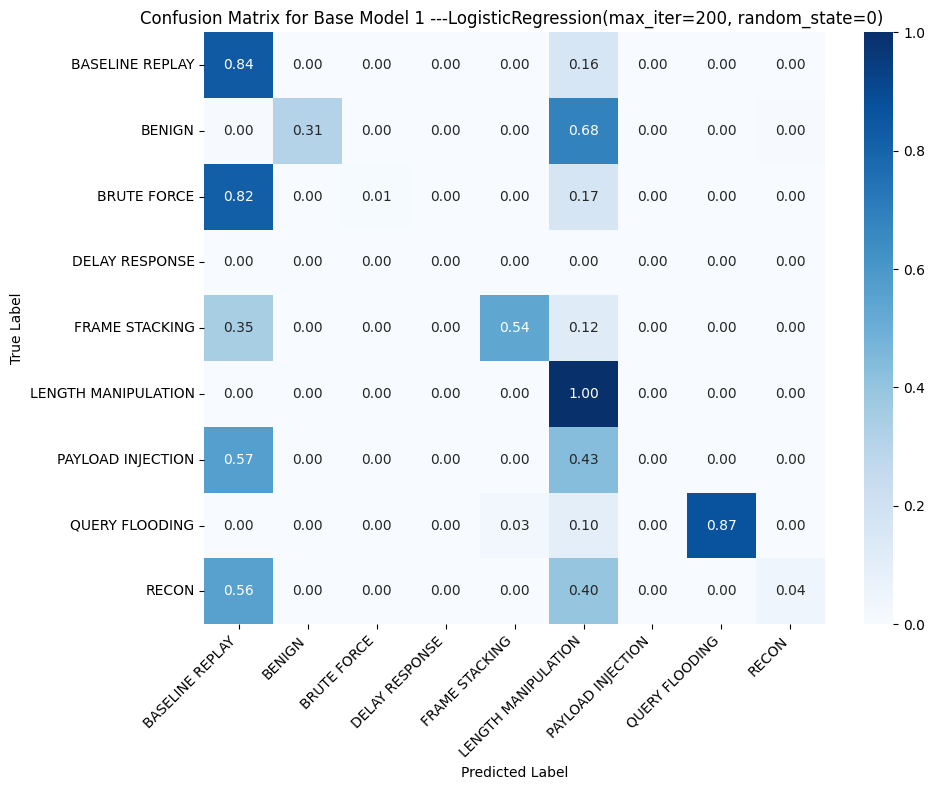


--- Training Base Model 2 ---LinearSVC(max_iter=200, random_state=0)


/home/hamid_rd3/labeling/Project1404/vnv/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/tmp/ipykernel_31880/2362505150.py:30: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


--- Evaluating Base Model 2 ---LinearSVC(max_iter=200, random_state=0) on Validation Set ---
Accuracy of Base Model 2: ---LinearSVC(max_iter=200, random_state=0)  0.4205
                     precision    recall  f1-score   support

    BASELINE REPLAY        nan      0.00      0.00       261
             BENIGN       0.19      1.00      0.32       244
        BRUTE FORCE        nan      0.00      0.00       235
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       0.90      0.55      0.68       254
LENGTH MANIPULATION       0.86      1.00      0.92       229
  PAYLOAD INJECTION        nan      0.00      0.00       260
     QUERY FLOODING       0.80      0.88      0.84       250
              RECON       0.92      0.04      0.08       267

           accuracy                           0.42      2000
          macro avg       0.73      0.43      0.35      2000
       weighted avg       0.74      0.42      0.35      2000



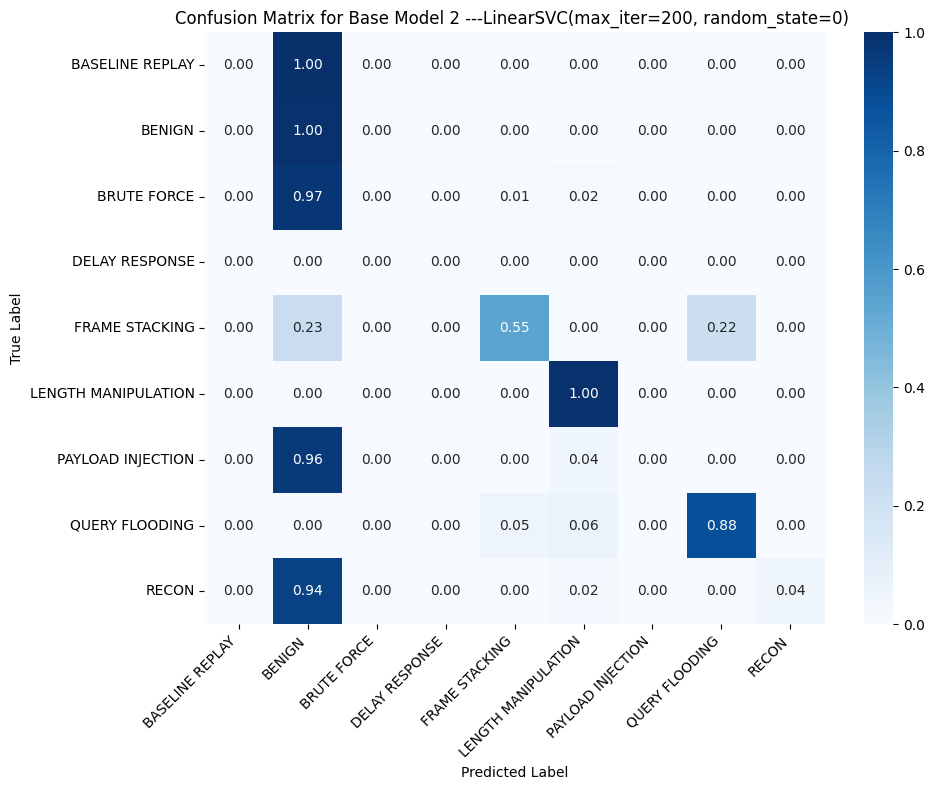


--- Training Base Model 3 ---GaussianNB()
--- Evaluating Base Model 3 ---GaussianNB() on Validation Set ---
Accuracy of Base Model 3: ---GaussianNB()  0.4235
                     precision    recall  f1-score   support

    BASELINE REPLAY       0.00      0.00      0.00       261
             BENIGN       0.88      0.31      0.46       244
        BRUTE FORCE       0.24      0.82      0.37       235
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       0.97      0.50      0.66       254
LENGTH MANIPULATION       0.30      1.00      0.47       229
  PAYLOAD INJECTION        nan      0.00      0.00       260
     QUERY FLOODING       1.00      0.88      0.94       250
              RECON       1.00      0.01      0.01       267

           accuracy                           0.42      2000
          macro avg       0.63      0.44      0.36      2000
       weighted avg       0.63      0.42      0.36      2000



/tmp/ipykernel_31880/2362505150.py:30: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


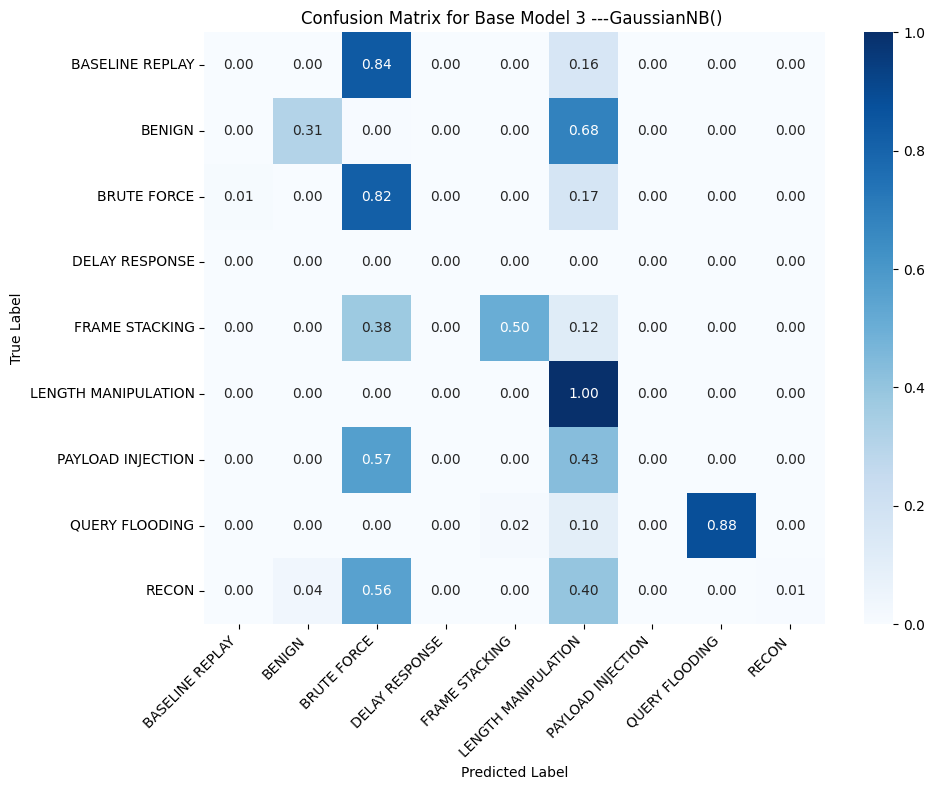


--- Training Base Model 4 ---RandomForestClassifier(n_estimators=50, random_state=0)
--- Evaluating Base Model 4 ---RandomForestClassifier(n_estimators=50, random_state=0) on Validation Set ---
Accuracy of Base Model 4: ---RandomForestClassifier(n_estimators=50, random_state=0)  0.9675
                     precision    recall  f1-score   support

    BASELINE REPLAY       0.98      0.96      0.97       261
             BENIGN       0.99      0.99      0.99       244
        BRUTE FORCE       0.91      0.86      0.88       235
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       1.00      1.00      1.00       254
LENGTH MANIPULATION       1.00      1.00      1.00       229
  PAYLOAD INJECTION       1.00      1.00      1.00       260
     QUERY FLOODING       1.00      1.00      1.00       250
              RECON       0.87      0.93      0.90       267

           accuracy                           0.97      2000
          macro avg       0.97      0.9

/tmp/ipykernel_31880/2362505150.py:30: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


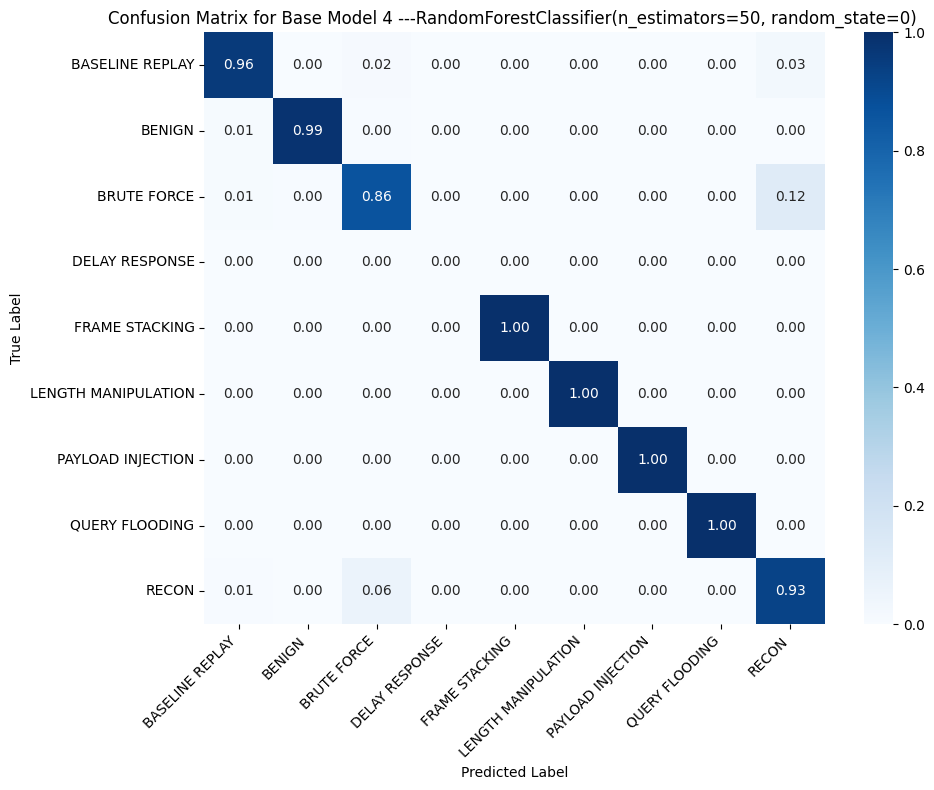


--- Training Base Model 5 ---DecisionTreeClassifier(random_state=0)
--- Evaluating Base Model 5 ---DecisionTreeClassifier(random_state=0) on Validation Set ---
Accuracy of Base Model 5: ---DecisionTreeClassifier(random_state=0)  0.9685
                     precision    recall  f1-score   support

    BASELINE REPLAY       0.96      0.95      0.96       261
             BENIGN       0.99      0.98      0.98       244
        BRUTE FORCE       0.90      0.91      0.91       235
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       1.00      1.00      1.00       254
LENGTH MANIPULATION       1.00      1.00      1.00       229
  PAYLOAD INJECTION       1.00      1.00      1.00       260
     QUERY FLOODING       1.00      1.00      1.00       250
              RECON       0.90      0.91      0.91       267

           accuracy                           0.97      2000
          macro avg       0.97      0.97      0.97      2000
       weighted avg       0.9

/tmp/ipykernel_31880/2362505150.py:30: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


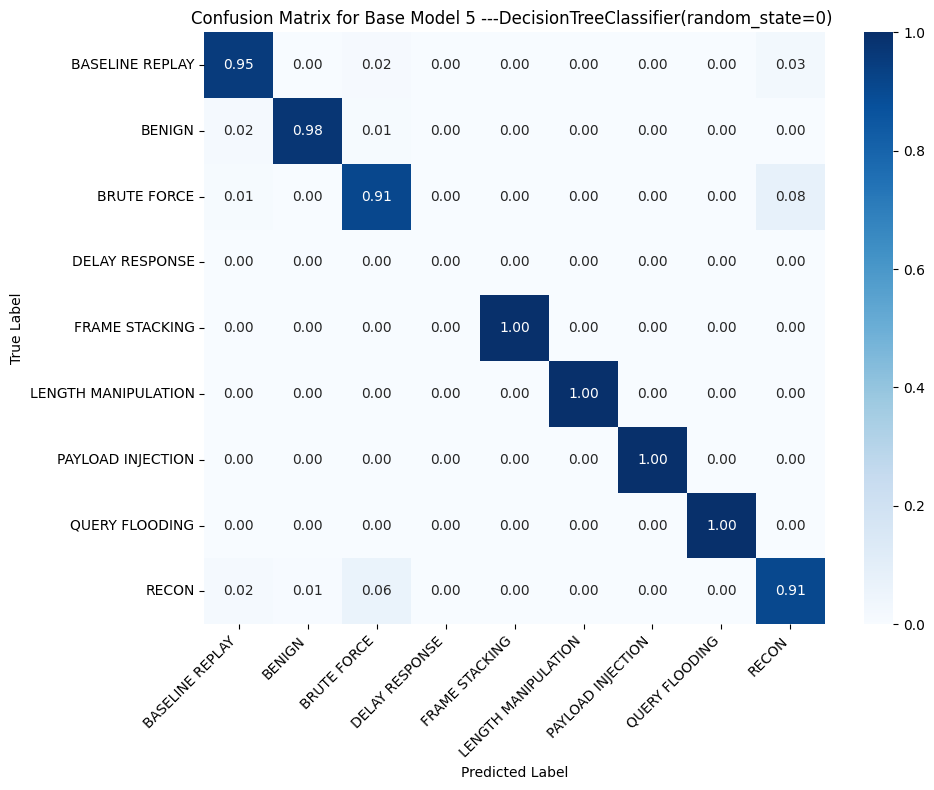


--- Training Base Model 6 ---DecisionTreeClassifier(criterion='entropy', random_state=0)
--- Evaluating Base Model 6 ---DecisionTreeClassifier(criterion='entropy', random_state=0) on Validation Set ---
Accuracy of Base Model 6: ---DecisionTreeClassifier(criterion='entropy', random_state=0)  0.9660
                     precision    recall  f1-score   support

    BASELINE REPLAY       0.95      0.95      0.95       261
             BENIGN       0.99      0.98      0.99       244
        BRUTE FORCE       0.90      0.88      0.89       235
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       1.00      1.00      1.00       254
LENGTH MANIPULATION       1.00      1.00      1.00       229
  PAYLOAD INJECTION       1.00      1.00      1.00       260
     QUERY FLOODING       1.00      1.00      1.00       250
              RECON       0.89      0.92      0.91       267

           accuracy                           0.97      2000
          macro avg       0

/tmp/ipykernel_31880/2362505150.py:30: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


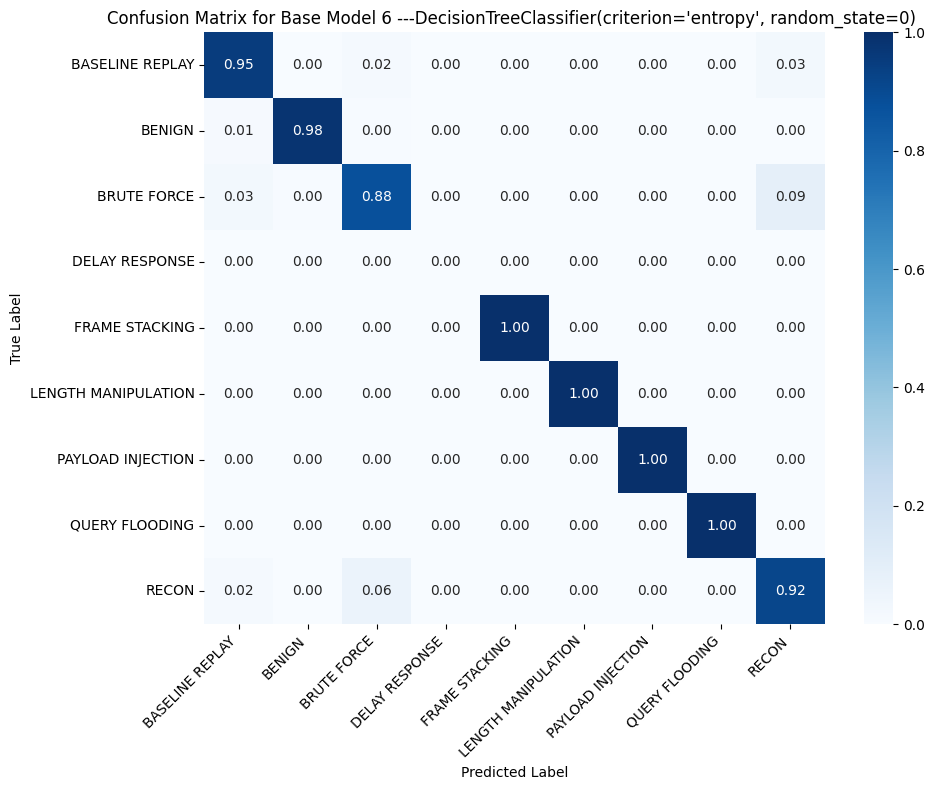


--- Training Base Model 7 ---KNeighborsClassifier(n_neighbors=3)
--- Evaluating Base Model 7 ---KNeighborsClassifier(n_neighbors=3) on Validation Set ---
Accuracy of Base Model 7: ---KNeighborsClassifier(n_neighbors=3)  0.9220
                     precision    recall  f1-score   support

    BASELINE REPLAY       0.89      0.89      0.89       261
             BENIGN       0.95      0.95      0.95       244
        BRUTE FORCE       0.76      0.75      0.75       235
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       1.00      1.00      1.00       254
LENGTH MANIPULATION       1.00      1.00      1.00       229
  PAYLOAD INJECTION       1.00      1.00      1.00       260
     QUERY FLOODING       1.00      1.00      1.00       250
              RECON       0.79      0.78      0.79       267

           accuracy                           0.92      2000
          macro avg       0.92      0.92      0.92      2000
       weighted avg       0.92      0.

/tmp/ipykernel_31880/2362505150.py:30: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


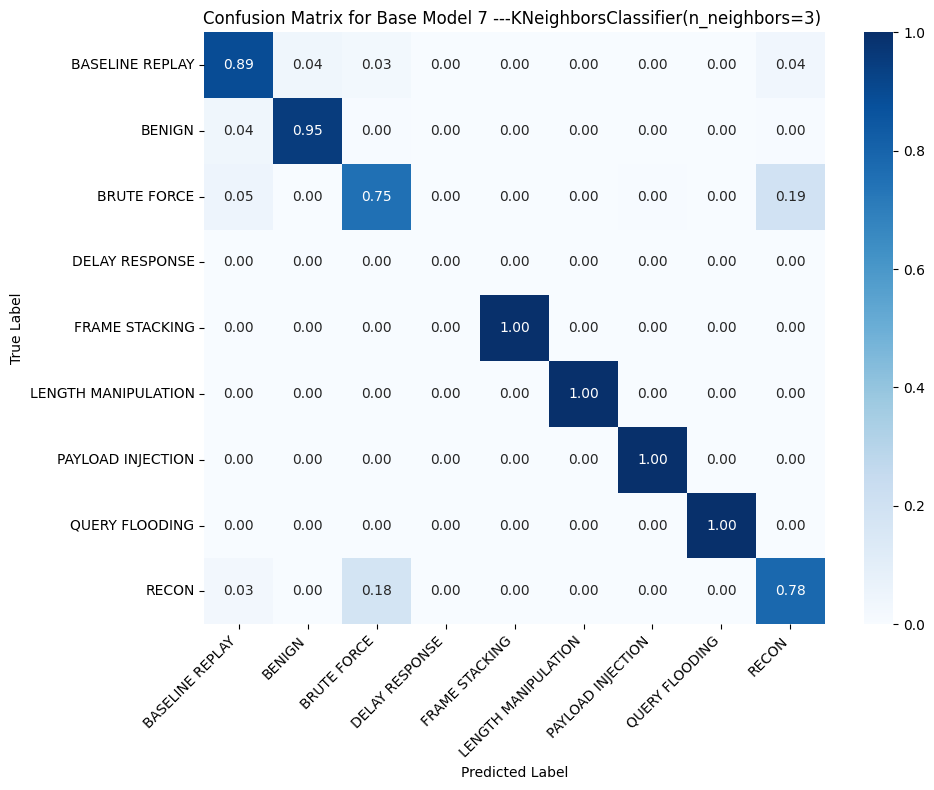


--- Training Base Model 8 ---HistGradientBoostingClassifier(max_iter=200, random_state=0)
--- Evaluating Base Model 8 ---HistGradientBoostingClassifier(max_iter=200, random_state=0) on Validation Set ---
Accuracy of Base Model 8: ---HistGradientBoostingClassifier(max_iter=200, random_state=0)  0.9820
                     precision    recall  f1-score   support

    BASELINE REPLAY       0.99      0.96      0.97       261
             BENIGN       1.00      0.98      0.99       244
        BRUTE FORCE       0.96      0.93      0.95       235
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       1.00      1.00      1.00       254
LENGTH MANIPULATION       1.00      1.00      1.00       229
  PAYLOAD INJECTION       1.00      1.00      1.00       260
     QUERY FLOODING       1.00      1.00      1.00       250
              RECON       0.92      0.98      0.95       267

           accuracy                           0.98      2000
          macro avg     

/tmp/ipykernel_31880/2362505150.py:30: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


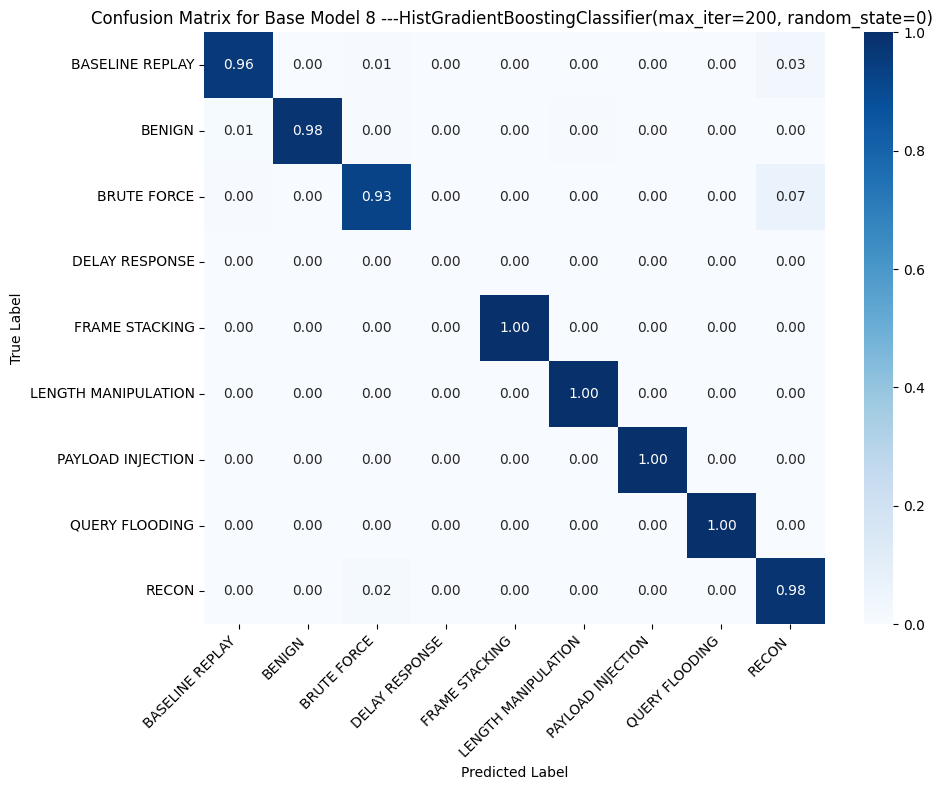

In [17]:
### Train on the Sampled distribution
train_evaluate(base_models,X_upsampled,y_upsampled,train_dataset.label_encoder,shuffle=True)